# GnomAD analysis
# Library import

In [1]:
from pathlib import Path
import os
import numpy
import pandas

In [2]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqUtils import seq1

In [3]:
from collections import Counter, defaultdict

In [4]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [5]:
import plotly.express as px
import plotly.graph_objects as go

# Importing the files
The raw files come in two sets. One is from GnomAD v3 and the other from GnomAD v2. The second is present as a backup if the mapping to the protein sequence from v3 fails.

In [6]:
_folder_path = Path() / "Raw_data"
_raw_files = [x for x in os.listdir(_folder_path) if os.path.isfile(_folder_path / x)]
_alternative_raw = [file for file in _raw_files if "2.1.1" in file]
_raw_files = list(set(_raw_files) - set(_alternative_raw))

We import the files as pandas DataFrame and add a column in which we track the gene of interest.

In [7]:
data = []
for file in _raw_files:
    data.append(pandas.read_csv(_folder_path / file))
    data[-1]["Gene"] = file.split(".")[-2].split("_")[-1]
data_alternative = []
for file in _alternative_raw:
    data_alternative.append(pandas.read_csv(_folder_path / file))
    data_alternative[-1]["Gene"] = file.split(".")[-2].split("_")[-1]

In [8]:
data[0]

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Hemizygote Count Ashkenazi Jewish,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene
0,X,152168157,NaN,G,A,gnomAD Genomes,NaN,PASS,c.*71C>T,NaN,...,0,0,30604,0,0,0,53112,0,0,GABRA3
1,X,152168161,rs1384790433,C,T,gnomAD Genomes,NaN,PASS,c.*67G>A,NaN,...,0,1,30550,0,0,2,53058,0,0,GABRA3
2,X,152168162,rs1386272230,G,A,gnomAD Genomes,NaN,PASS,c.*66C>T,NaN,...,0,0,30614,0,0,3,53127,0,2,GABRA3
3,X,152168165,rs1603193519,G,A,gnomAD Genomes,NaN,PASS,c.*63C>T,NaN,...,0,1,30665,0,0,0,53180,0,0,GABRA3
4,X,152168167,rs1453252241,T,C,gnomAD Genomes,NaN,PASS,c.*61A>G,NaN,...,0,1,30551,0,0,0,53035,0,0,GABRA3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,X,152364593,rs1462667747,A,G,gnomAD Genomes,NaN,PASS,c.-23T>C,NaN,...,0,2,30588,0,1,0,53123,0,0,GABRA3
341,X,152364614,rs200503915,T,G,gnomAD Genomes,NaN,PASS,c.-26-18A>C,NaN,...,0,1,30551,0,0,8,53051,0,4,GABRA3
342,X,152364618,rs1380023644,T,A,gnomAD Genomes,NaN,PASS,c.-26-22A>T,NaN,...,0,0,30462,0,0,1,52933,0,0,GABRA3
343,X,152364628,rs1219359555,G,A,gnomAD Genomes,NaN,PASS,c.-26-32C>T,NaN,...,0,1,30672,0,0,0,53088,0,0,GABRA3


# Joining the datasets
We join both the main dataset and the alternative one. Some columns are present only in a subset of files. We will keep them when joining the datasets, and introduce NaN where we have no data.

The joining gives us 28,738 variants to work with.

In [10]:
dataset = pandas.concat(data, axis=0, join="outer", ignore_index=True)
dataset_alternative = pandas.concat(data_alternative, axis=0, join="outer", ignore_index=True)

In [11]:
dataset.shape

(28738, 62)

# Exploring the full dataset
## Different polymorphism annotations
For a complete description of the effect annotations see [the ensembl description](https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html).
Only a subset of all the possible annotations is present. Here we focus only on the ones that result in a difference in the protein product. We collect the annotation labels into a list we can invoke later on.

In [12]:
dataset["VEP Annotation"].unique()

array(['3_prime_UTR_variant', 'stop_retained_variant', 'missense_variant',
       'synonymous_variant', 'splice_region_variant', 'intron_variant',
       'stop_gained', '5_prime_UTR_variant', 'splice_acceptor_variant',
       'start_lost', 'frameshift_variant', 'splice_donor_variant',
       'inframe_deletion', 'stop_lost', 'inframe_insertion', nan,
       'protein_altering_variant'], dtype=object)

In [13]:
_VEPs = ["missense_variant",
         "stop_gained",
         "splice_acceptor_variant",
         "splice_donor_variant",
         "frameshift_variant",
         "inframe_deletion",
         "inframe_insertion",
         "start_lost",
         "stop_lost",
         "protein_altering_variant"]

We see that the majority of the mutations of interest get classified into missense mutations (note that the visuals below only look at the labels of interest; though in the first graph the proportion is normalized to the size of the whole dataset, in the pie chart the total is equal to the number of the mutations of interest). As such, it might make sense to discuss if we would be better off disregarding all the other types of mutations just to make our life easier in terms of the analysis. In any event the proportions of different mutation types should probably be shown. 

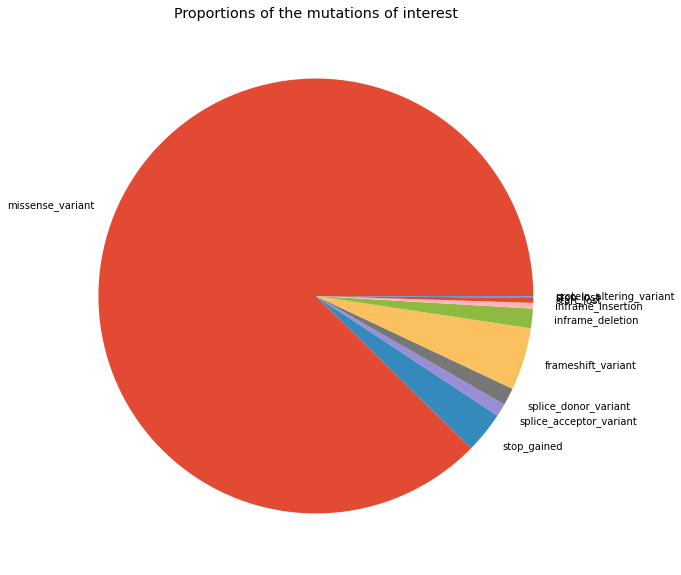

In [15]:
_counts = [sum(dataset["VEP Annotation"] == x)  for x in _VEPs]
_total = sum(_counts)
_counts = [x/_total for x in _counts]
pyplot.pie(_counts, labels=_VEPs)
pyplot.title("Proportions of the mutations of interest")
pyplot.show()

# Filtering

Before filtering anything else, we will discard all the data points where the total allele number deviates too much.

In [16]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [18]:
_mean_af = dataset["Allele Number"].mean()
_std_af = dataset["Allele Number"].std()
print(f"Mean: {_mean_af}\nS. dev.: {_std_af}")

Mean: 148916.9469892099
S. dev.: 11639.162625345722


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


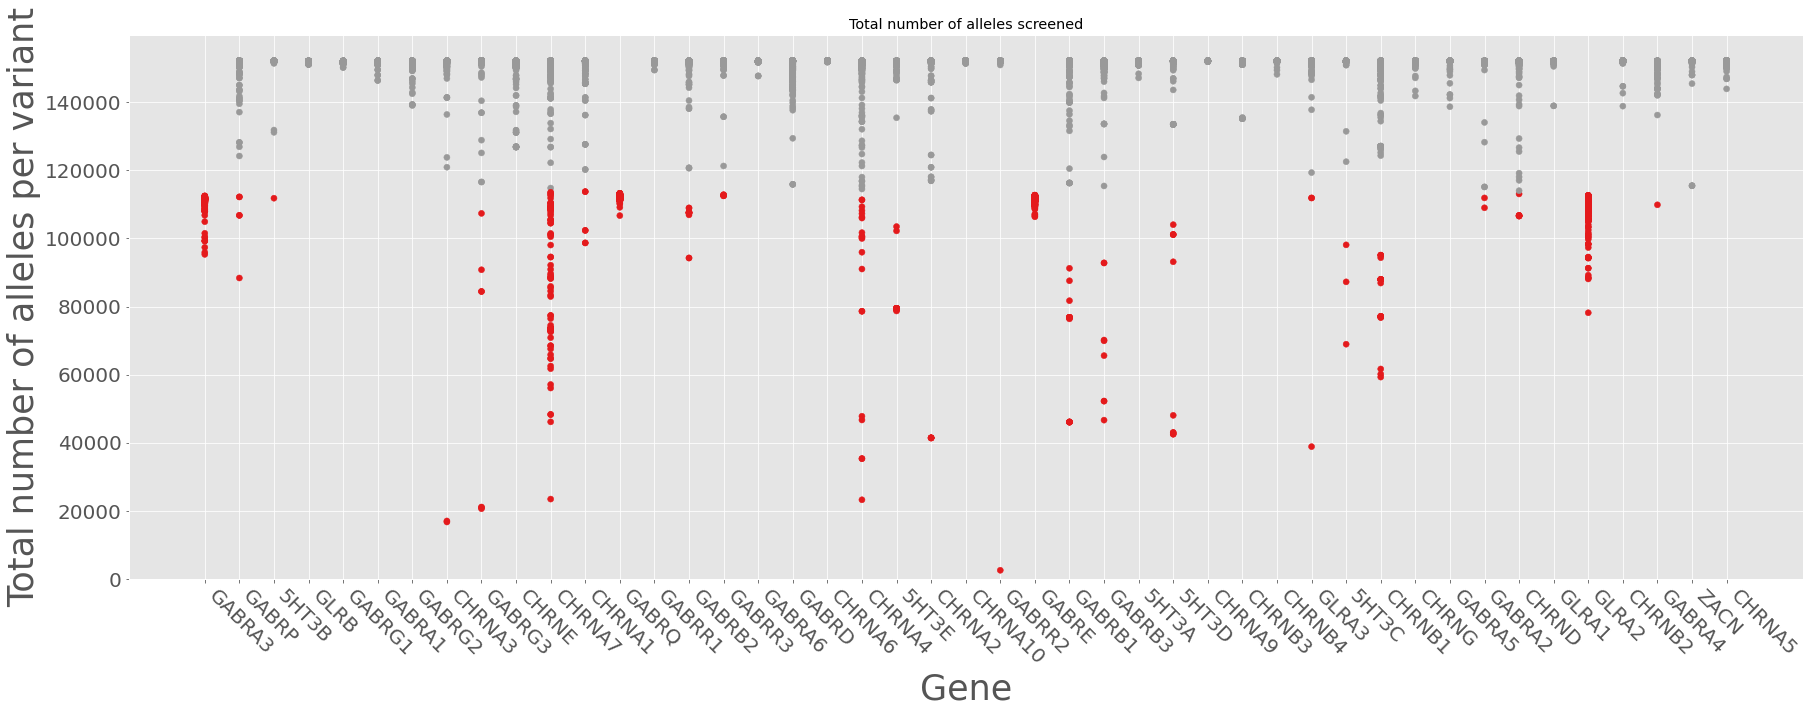

In [22]:
dataset["Retained"] = dataset.apply(lambda x: abs(x["Allele Number"] - _mean_af) < 3*_std_af, axis=1)

fig, ax = pyplot.subplots()
pyplot.scatter(dataset["Gene"], dataset["Allele Number"], c=dataset["Retained"], cmap="Set1")
pyplot.xticks(rotation=-45, horizontalalignment="left", size=20)
pyplot.setp(ax.get_yticklabels(), size=20)
pyplot.xlabel("Gene", size=35)
pyplot.ylabel("Total number of alleles per variant", size=35)

pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
fig.show()

fig.savefig("Export/Total_alleles.png", format="png", dpi=300, bbox_inches="tight")

In [23]:
dataset = dataset[dataset.apply(lambda x: abs(x["Allele Number"] - _mean_af) < 3*_std_af, axis=1)]

Next we filter only for the GnomAD data in case another type was also present.

In [24]:
dataset = dataset[dataset["Source"] == "gnomAD Genomes"]
dataset.reset_index(inplace=True)

In [26]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

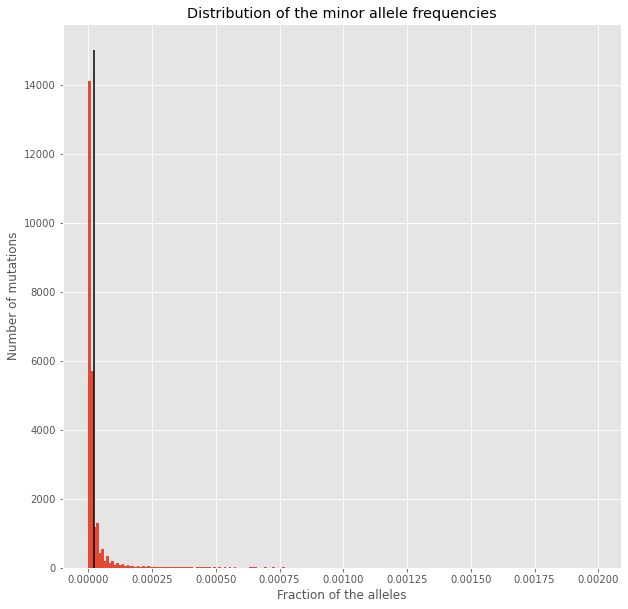

In [28]:
pyplot.hist(dataset["Allele Count"]/dataset["Allele Number"], bins=[x*0.00001 for x in range(0, 200)])
pyplot.vlines([0.00002], ymin=0, ymax=15000, colors="black")
pyplot.xlabel("Fraction of the alleles")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele frequencies")
pyplot.show()

We filter by including only variants present in at least 0.001 % of the population (black vertical line above).

In [31]:
subdata = dataset[dataset["Allele Count"]/dataset["Allele Number"] > 0.00001]
subdata = subdata[subdata["VEP Annotation"].isin(_VEPs)]

If we look at the distribution of mutations across the annotation labels as before, we see that the distribution has become even more skewed towards the missense variants.

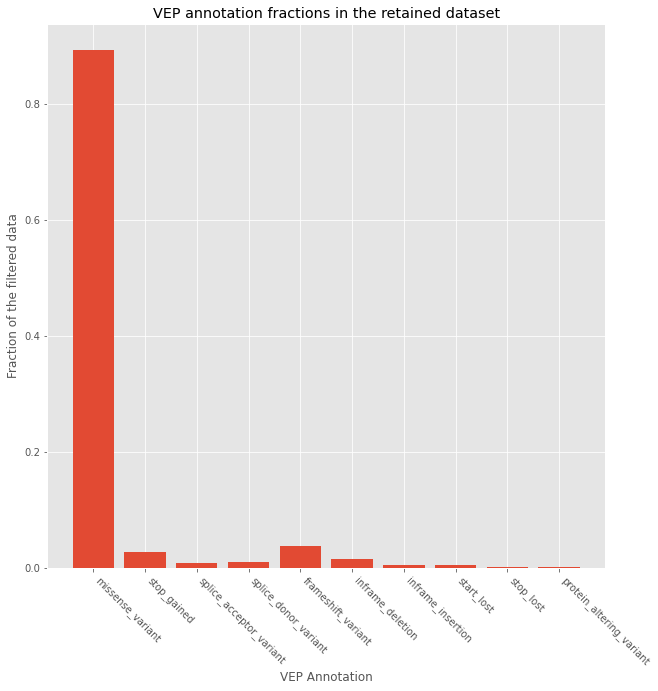

In [32]:
pyplot.bar(_VEPs, [sum(subdata["VEP Annotation"] == x)/subdata.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the filtered data")
pyplot.title("VEP annotation fractions in the retained dataset")
pyplot.show()

# Distribution of variants across the genes
First we just look at the number of different polymorphisms detected for each gene.

In [33]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [34]:
_genes = subdata["Gene"].unique()
_values = pandas.DataFrame({"Gene": _genes, "Value": [sum(subdata["Gene"] == x)/subdata.shape[0]  for x in _genes]})
_values.sort_values(by="Value", ascending=False, inplace=True, ignore_index=True)

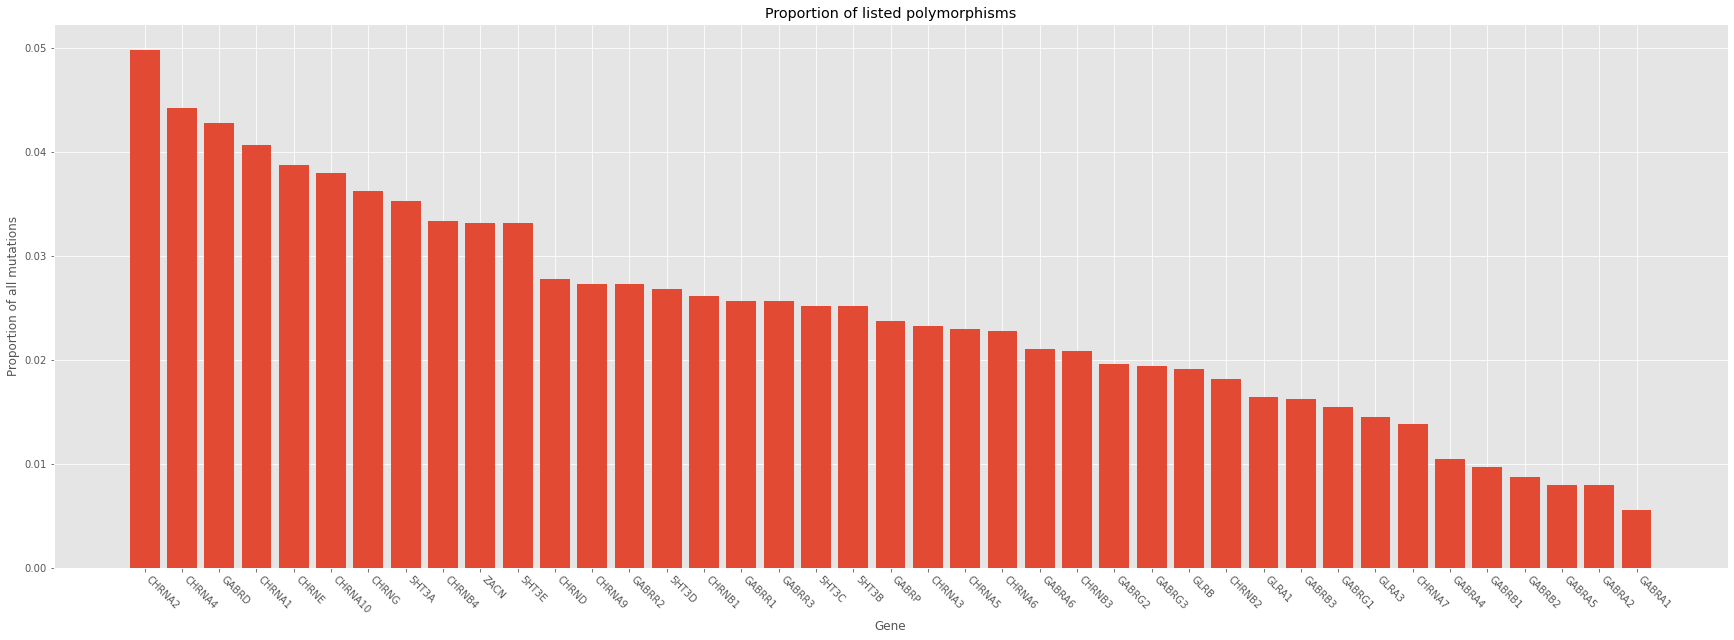

In [35]:
pyplot.bar(_values["Gene"], _values["Value"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Proportion of all mutations")
pyplot.title("Proportion of listed polymorphisms")
pyplot.show()

Next we look at the allele counts across all the mutations for single genes to get a feeling for which genes drive the statistical power in our sample. 

In [36]:
_values["Allele Count"] = [sum(subdata["Allele Count"][subdata["Gene"] == x]) for x in _values["Gene"]]
_values.sort_values(by="Allele Count", ascending=False, inplace=True, ignore_index=True)

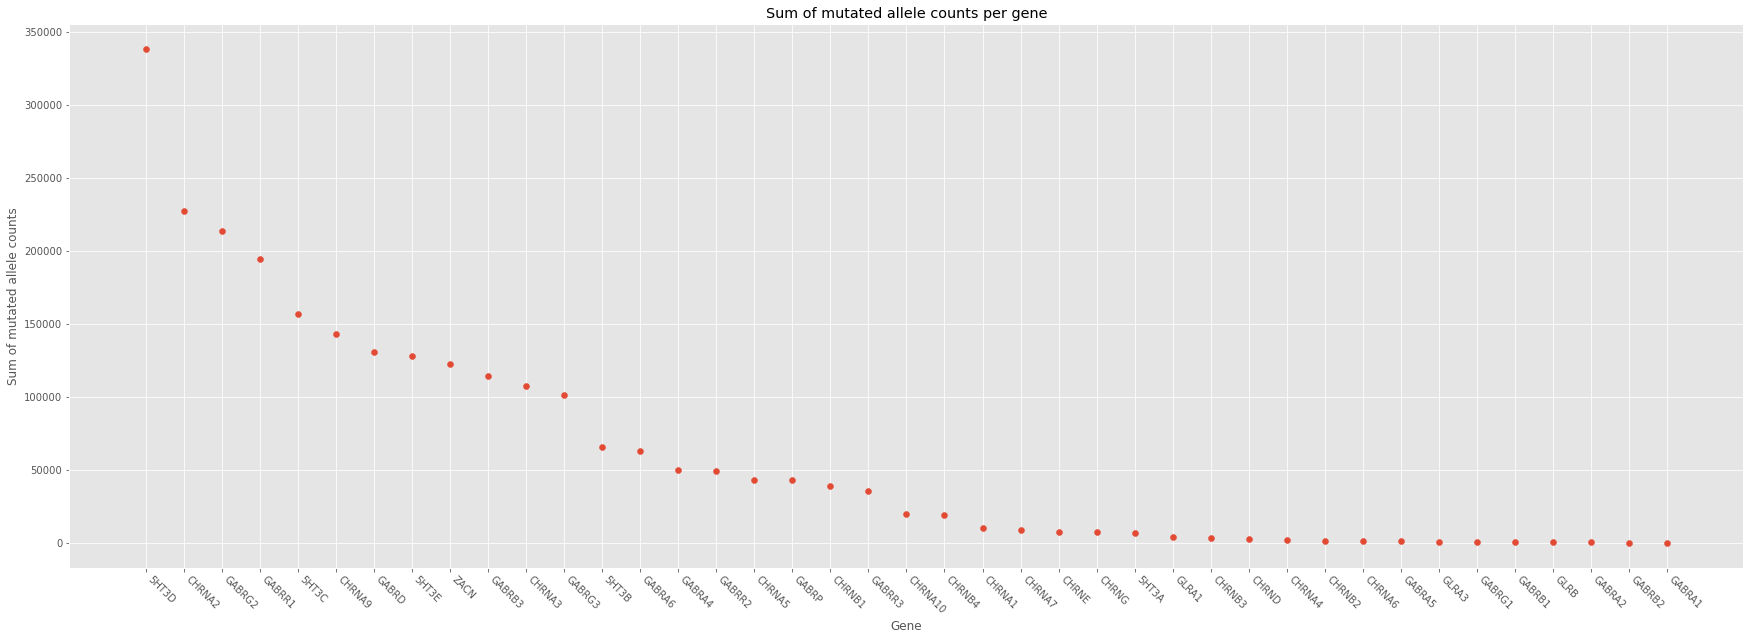

In [37]:
pyplot.scatter(_values["Gene"], _values["Allele Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Sum of mutated allele counts")
pyplot.title("Sum of mutated allele counts per gene")
pyplot.show()

Beyond this point we will focus on only missense variants, so we extract those.

In [42]:
missense = subdata[subdata["VEP Annotation"] == "missense_variant"]
missense["AA Number"] = missense["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32")
missense.reset_index(inplace=True)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Mapping to a common alignment

## Producing the alignment
The alignment was produced through predicted structures by AlphaFold. The sequences used in the prediction are human reference sequences from UniProt, so the predicted structures should be complete. After fetching all the structures, these were imported into MOE session, where they were aligned. First, a global `optimized for superposition` alignment was performed. After that, sequence of the domain between TM3 and TM4 was separately aligned with `sequence only alignment` option. This part of structures is highly mobile, but is also less important for the comparison.The sequence before the first beta sheet was aligned with the help of known structures. 

Afterwards extra sequences were added for the proteins which had an unmappable mutations. This was necessary as the reference sequence for a lot of mutations is not the main sequence on UniProt. 

## Using the alignment

We create a class to encapsulate the alignment and pack in it all the functions we would need for interacting with it.

The current functions are:
1. `convert_to_reference` ==> given name of the sequence, amino acid code and number it finds the amino acid in the sequence and returns the position of it in the full reference alignment.
2. `find_reference` ==> searches the amino acid through all the available isoforms of a gene by calling `convert_to_reference` on all the isoforms of a given gene and giving the first positive return.
3. `filter_sequence` ==> shortens the sequence by discarding the segments where either only one sequence or a signle gene has sequence present. In reality the class retains the full alignment but just produces a mapping for new numbering.
4.  `convert_to_filtered` ==> given the sequential number in the full alignment it returns the position in the filtered sequence. If the position was discarded it gives -1.
5. `aa_to_filtered` ==> given gene, amino acid code and numbering in the gene sequence it returns the position in the filtered sequence.
6. `reference_to_aa` ==> given the reference number and the gene, it returns the single character amino acid code and the number of that amino acid in the specified gene sequence

In [38]:
class Alignment:
    def __init__(self, alignment_file) -> None:
        self._alignment = AlignIO.read(alignment_file, "clustal")
        self._sequences = {sequence.id: sequence for sequence in self._alignment}
        self.alignment_subunits = self._sequences.keys()
    
    def convert_to_reference(self, id, acid, number):
        """
        Returns the position in the reference sequence (STARTING FROM 1) if found, else -1.
        The provided number also must start the amino acid count with 1.
        """
        if len(acid) == 3:
            acid = seq1(acid)

        sequence = self._sequences[id]

        # Edge case if the number is higher than the length of the sequence
        if number > len(str(sequence.seq).replace("-", "")):
            return -1

        i = 0
        for j, residue in enumerate(sequence):
            if residue != "-":
                i = i+1
                if i == number:
                    if residue == acid:
                        return j+1
                    else:
                        return -1

    def find_reference(self, gene, aacid, number):
        """
        Goes through all the internal isoforms of the selected gene and runs a reference run
        till it finds a match. Else it returns -1.
        """
        subunits = pandas.Series([sub for sub in self.alignment_subunits if gene in sub])
        result = subunits.apply(lambda x: self.convert_to_reference(x, aacid, number))
        return -1 if sum(result == -1) == len(result) else result[result != -1].iloc[0]
    
    def filter_sequence(self, group_isoforms=False):
        """
        Discards the positions of the alignment which are in the middle of 3 consequtive single-sequence occupied alignment subsequence.
        If group_isoforms is true it considers hits on multiple isoforms of the same gene as 1 hit. 
        """
        # self._original_sequences = self._sequences
        # self._original_alignment = self._alignment

        if group_isoforms:
            genes = pandas.Series([key for key in self._sequences.keys() if not "_" in key])
            # Note we pad the sequence with one 1 on each side. This is used just in the creation of the mask so we can properly process the first and last value
            sequence_count = numpy.pad(numpy.array([numpy.array([[y != "-" for y in ali_class._sequences[key]] for key in ali_class._sequences.keys() if gene in key]).any(axis=0) for gene in genes]).sum(axis=0), (1, 1), "constant", constant_values=1)
        else:
            sequence_count = numpy.array([1] + [len(self._alignment[:, i].replace("-", "")) for i in range(0, len(self._alignment[0]))] + [1])
        
        mask = numpy.array([(x > 1) or (y > 1) or (z > 1) for x, y, z in zip(sequence_count, sequence_count[1:], sequence_count[2:])])
        
        self.precomputed_filter = []
        j = 1
        for i, mask_value in enumerate(mask):
            if mask_value:
                self.precomputed_filter.append(j)
                j += 1
            else:
                self.precomputed_filter.append(-1)
    
    def convert_to_filtered(self, position):
        """"
        Takes the position in the reference sequence and converts it to the filtered reference position.
        If the position got discarded through filtering it returns -1.
        """
        return self.precomputed_filter[int(position)]

    def aa_to_filtered(self, gene, aacid, number):
        """
        Converts the amino acid to the filtered amino acid sequence using find_reference and convert_to_filtered.
        """
        referenced = self.find_reference(gene, aacid, number)
        if referenced != -1:
            referenced = self.convert_to_filtered(referenced)
        return referenced

    def reference_to_aa(self, position, gene):
        """
        Takes the position and returns the tuple containing the amino acid and sequential position on the given gene.
        """
        # slice the gene sequence at the position and take everything before it
        # check if the last amino acid is "-"
        # remove "-"
        # length
        sequence = self._sequences[gene][:position]
        if sequence[-1] == "-":
            return ("-", -1)
        return sequence[-1], len(str(sequence.seq).replace("-", ""))

We initiate the alignment class on our alignment and test it on a positive and negative examples. Then we apply it over the dataset.

In [39]:
ali_class = Alignment("Alignment.aln")
print(f'This should return 88: {ali_class.find_reference("GABRA1", "T", 20)}')
print(f'This should return -1: {ali_class.find_reference("GABRA1", "T", 23)}')

This should return 88: 88
This should return -1: -1


In [43]:
missense["AA Referenced"] = missense.apply(lambda x: ali_class.find_reference(x["Gene"], x["Protein Consequence"].split(".")[1][0:3], x["AA Number"]), axis=1)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


How many of the amino acids did we fail to map?

In [47]:
print("Number of AAs that failed to map: ", sum(missense["AA Referenced"] == -1))
print("Proportion of AAs that failed to map: ", sum(missense["AA Referenced"] == -1) / missense.shape[0])

# Check also NaN-s just in case they were introduced - in that case something in the class is not working properly
print("Number of NaNs introduced: ", sum(missense["AA Referenced"].isna()))

Number of AAs that failed to map:  52
Proportion of AAs that failed to map:  0.014084507042253521
Number of NaNs introduced:  0


For some SNPs the change in reference genome assembly changed the protein change assignment to an incorrect one.
For these cases we use the following protocol:

1. Use the GnomAD v2 assignments in the cases where there is an entry present. If this is not successful, then
2. Use the alternative alignments to see if the mutation might have been mapped onto a non-main transcript.

In [48]:
for i in range(0, missense.shape[0]-1):
    if missense.iloc[i]["AA Referenced"] == -1:
        if missense.iloc[i]["rsIDs"] is None:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["Transcript Consequence"] == missense.iloc[i]["Transcript Consequence"])]
        else:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["rsIDs"] == missense.iloc[i]["rsIDs"])]
        if not x.empty and x["Protein Consequence"].any():
            missense.at[i, "AA Referenced"] = ali_class.find_reference(missense.iloc[i]["Gene"],
                                                    x["Protein Consequence"].str.split(".").values.tolist()[0][1][0:3],
                                                    x["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32").values.tolist()[0][0])

Did this reduce the number of unmapped amino acids?

In [49]:
print("Number of AAs that failed to map: ", sum(missense["AA Referenced"] == -1))
print("Proportion of AAs that failed to map: ", sum(missense["AA Referenced"] == -1) / missense.shape[0])

Number of AAs that failed to map:  31
Proportion of AAs that failed to map:  0.008396533044420368


We managed to reduce the number of non-mapped mutations. Let's see the remaining ones are distributed throught the genes.

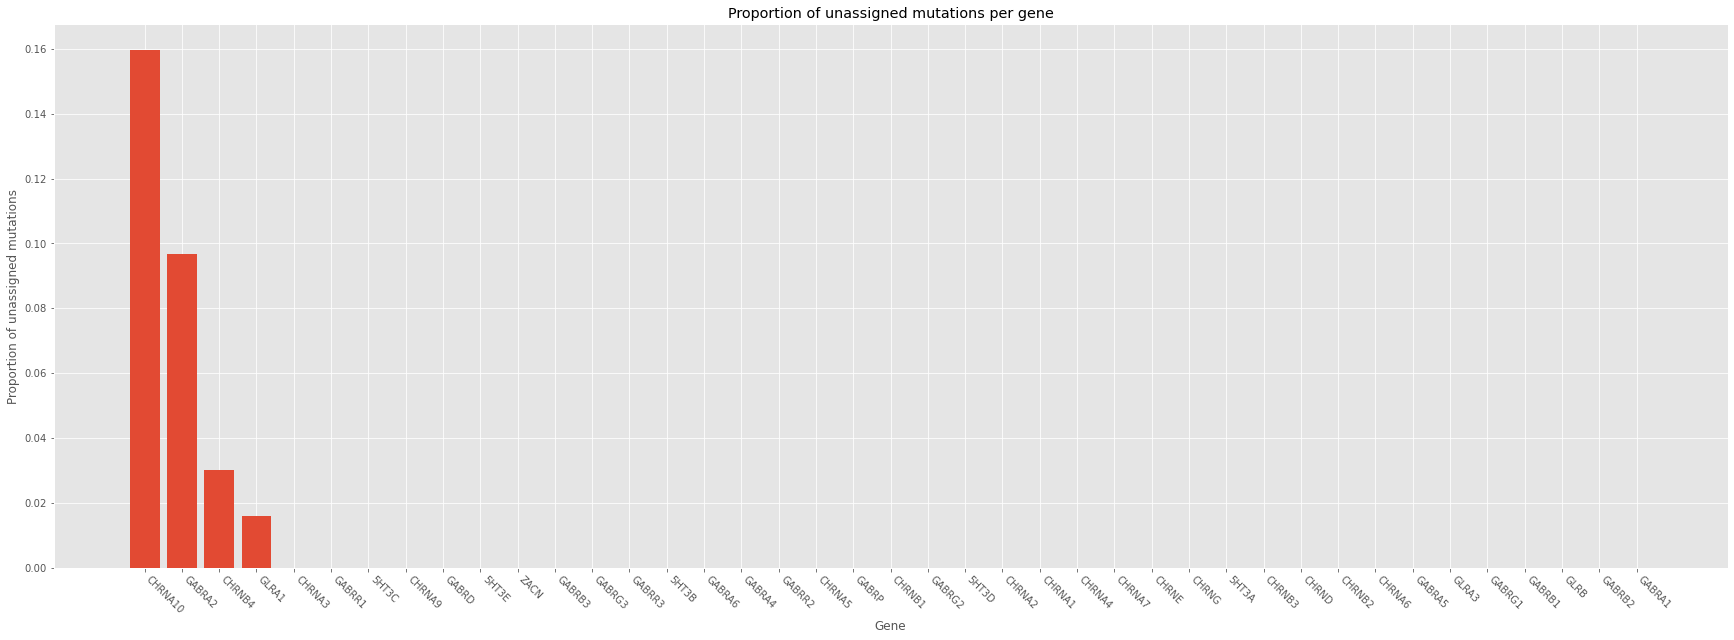

In [51]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]) / sum(missense["Gene"] == x["Gene"]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.bar(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Proportion of unassigned mutations")
pyplot.title("Proportion of unassigned mutations per gene")
pyplot.show()

**Note:**

- CHRNA10: has an extra protein coding transcript, which cannot be reliably aligned to the main transcript, so we cannot add it.
- very short sequences (<100 AA) were automatically excluded

We have for now 0.8 % of SNPs where the numbering of amino acid was incorrect.

For now we check where we find the variants in the reference sequence. There seem to be several hot spots. Note that the parts without signal don't necessarily mean a spot that is mutation-free, but might be a part of the protein that is tolerating the mutations better.

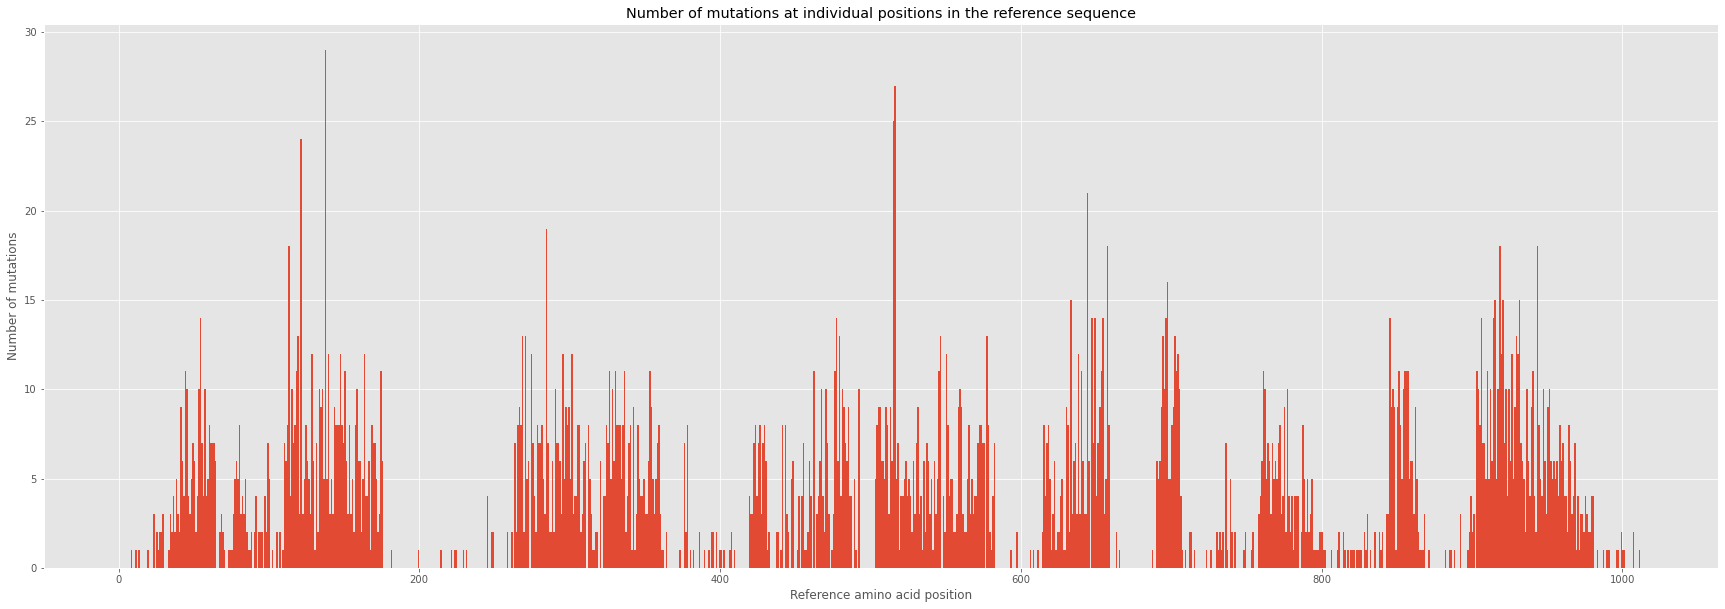

In [53]:
found_missense = missense[missense["AA Referenced"] != -1]
pyplot.hist(found_missense["AA Referenced"], bins=[x for x in range(1, len(ali_class._alignment[0]))])
pyplot.xlabel("Reference amino acid position")
pyplot.ylabel("Number of mutations")
pyplot.title("Number of mutations at individual positions in the reference sequence")
pyplot.show()

# Mapping to structural elements
We have a list of the amino acids involved in the structural elements written in a CSV file. These are the structural elements that were mapped to GABRA1 sequence. We load them in, transform them to the reference numbering and use them as a reference to annotate the table of mutations.

In [55]:
structural_elements = pandas.read_csv("Structural_elements.csv")
structural_elements

,Gene,AA Name,AA Number,BS
0,GABRA1,Y,252,TM1
1,GABRA1,F,253,TM1
2,GABRA1,V,254,TM1
3,GABRA1,I,255,TM1
4,GABRA1,Q,256,TM1
...,...,...,...,...
394,GABRA1,S,417,ICD
395,GABRA1,K,418,ICD
396,GABRA1,I,419,ICD
397,GABRA1,D,420,ICD


First we need to put our amino acids on the reference sequence. We apply it to every row in the table.

In [57]:
structural_elements["AA Referenced"] = structural_elements.apply(lambda x: ali_class.find_reference(x["Gene"], x["AA Name"], x["AA Number"]) , axis=1)
# We add the entry for marking the start of ECD from the beginning of all sequences
structural_elements = pandas.concat([structural_elements, pandas.DataFrame.from_dict({"Gene": [""], "AA Name": [""], "AA Number": [0], "BS": ["ECD"], "AA Referenced": [1]})], ignore_index=True)

We convert different structural elements to ranges by finding their minimum and maximum number. We use these to apply ranges to the data table. This way each variant in the data table has a structural element assigned to it. Note the structural elements don't overlap. Furthermore, the transmembrane domain is separated into it's 4 alpha helices. We can also see that some variants remain unclassified. 

In [60]:
found_missense["Region"] = ""
for element in structural_elements["BS"].unique():
    found_missense.at[(found_missense["AA Referenced"] >= min(structural_elements["AA Referenced"][structural_elements["BS"] == element])) & (found_missense["AA Referenced"] <= max(structural_elements["AA Referenced"][structural_elements["BS"] == element])), "Region"] = element

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Let's first check how the variants are distributed in different structural elements. We will visualize individual TM helices, but also include a sum of them as a full TM domain.

In [61]:
region_count = Counter(found_missense["Region"])
region_count["TM"] = sum([region_count[key] for key in region_count.keys() if key.startswith("TM")])
region_count

Counter({'ECD': 1879,
         'TM1': 99,
         '': 189,
         'TM2': 110,
         'TM3': 111,
         'ICD': 1141,
         'TM4': 132,
         'TM': 452})

In [65]:
region_count = Counter(found_missense["Region"])
region_count["TM"] = sum([region_count[key] for key in region_count.keys() if key.startswith("TM")])
region_count = pandas.DataFrame.from_dict({"Region": list(region_count.keys()), "Count": list(region_count.values())})
region_count.at[region_count["Region"] == "", "Region"] = "Unassigned"

# Finding lengths of individual segments
region_count["Length"] = 0
region_count["Length"] = region_count.apply(lambda y: (structural_elements["AA Referenced"][structural_elements["BS"] == y["Region"]]).max() - (structural_elements["AA Referenced"][structural_elements["BS"] == y["Region"]]).min() + 1, axis=1)
# Summing up all the TMD segments
region_count.at[region_count["Region"] == "TM", "Length"] = region_count["Length"][region_count["Region"].str.startswith("TM")].sum()
# Finding the length of the unassigned segments
region_count.at[region_count["Region"] == "Unassigned", "Length"] = len(ali_class._alignment[0]) - region_count["Length"].sum()

# Normalizing to the lengths
region_count["Relative"] = region_count["Count"] / region_count["Length"]

region_count

,Region,Count,Length,Relative
0,ECD,1879,520.0,3.613462
1,TM1,99,22.0,4.500000
2,Unassigned,189,13.0,14.538462
3,TM2,110,22.0,5.000000
4,TM3,111,22.0,5.045455
5,ICD,1141,305.0,3.740984
6,TM4,132,22.0,6.000000
7,TM,452,88.0,5.136364


We first plot the total number of variants in each segment.

In [66]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

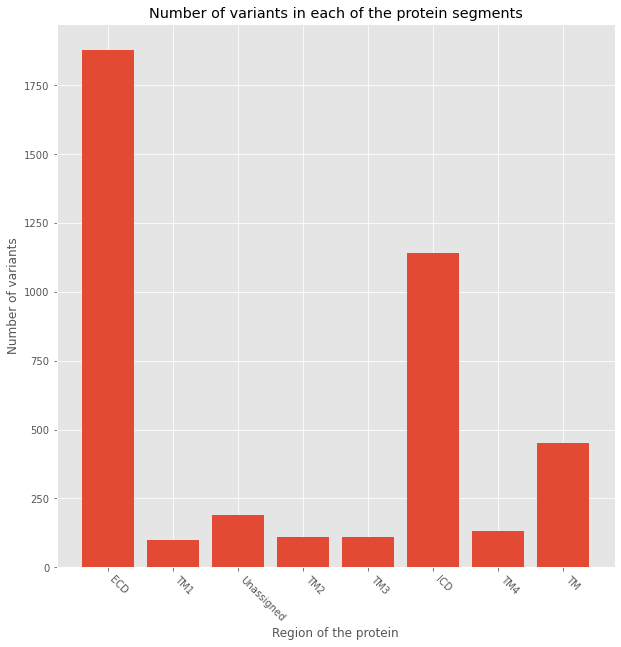

In [67]:
pyplot.bar(region_count["Region"], region_count["Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Region of the protein")
pyplot.ylabel("Number of variants")
pyplot.title("Number of variants in each of the protein segments")
pyplot.show()

Next we visualize the relative number of variants per segment. For this we divided the total number of variants in each segment with its length. As the last column we also add in a blue color data for the full length of the reference sequence.  

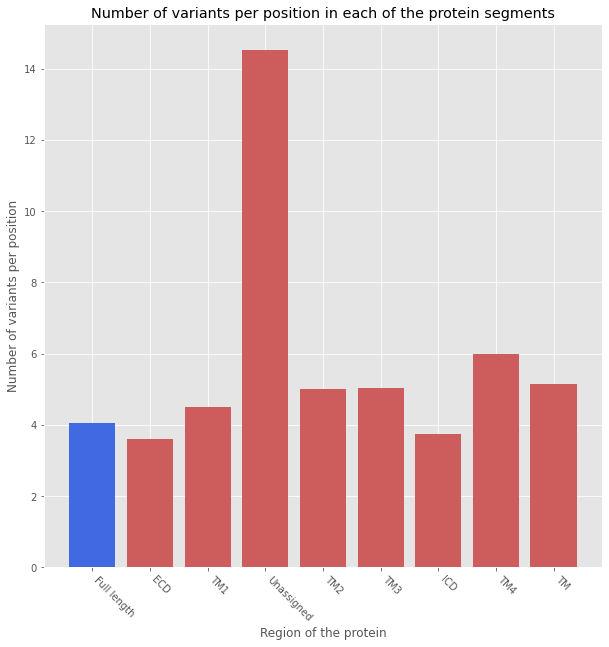

In [68]:
pyplot.bar(["Full length"], [region_count["Count"].sum()/region_count["Length"].sum()], color="royalblue")
pyplot.bar(region_count["Region"], region_count["Relative"], color="indianred")
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Region of the protein")
pyplot.ylabel("Number of variants per position")
pyplot.title("Number of variants per position in each of the protein segments")
pyplot.show()

Next we will count the number of variants on each position in the reference sequence.

In [72]:
positional_variants = missense["AA Referenced"][~missense["AA Referenced"].isna()]
positional_variants = positional_variants[positional_variants != -1]
# Spawning every position with a default value (0.0) if it does not exist
positional_variants = defaultdict(float, Counter(positional_variants))
for i in range(1, len(ali_class._alignment[0])+1):
    positional_variants[i]
positional_variants = pandas.DataFrame.from_dict({"AA Referenced": list(positional_variants.keys()), "Count": list(positional_variants.values())})

Asigning regions to the segments.

In [74]:
# Annotating regions
positional_variants["Region"] = ""
for element in structural_elements["BS"].unique():
    positional_variants["Region"][(positional_variants["AA Referenced"] > min(structural_elements["AA Referenced"][structural_elements["BS"] == element])) & (positional_variants["AA Referenced"] < max(structural_elements["AA Referenced"][structural_elements["BS"] == element]))] = element

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [76]:
# Checking the number of amino acids present per position in the alignment
positional_count = numpy.array([len(ali_class._alignment[:, i].replace("-", "")) for i in range(0, len(ali_class._alignment[0]))])

A lot of the positions is occupied by a single sequence. We should probably discard those. Note though that they could be just a single position. In that case we will probably want to retain them.

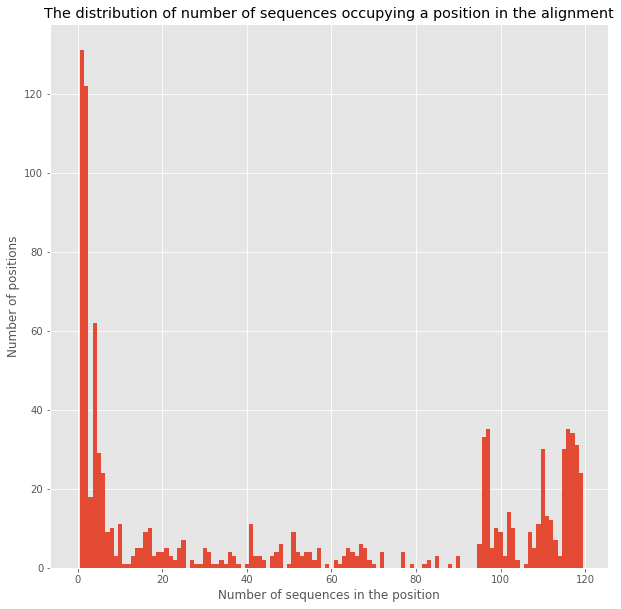

In [77]:
pyplot.hist(positional_count, bins = range(0, max(positional_count)), lw=0, align="left", )
pyplot.title("The distribution of number of sequences occupying a position in the alignment")
pyplot.xlabel("Number of sequences in the position")
pyplot.ylabel("Number of positions")
pyplot.show()

For each position with a single amino acid in it we will discard it if the neighboring positions also have a single amino acid. We will also regard isoforms of a individual gene as one. So we first compute a mask, which we then apply to the whole sequence.

In [82]:
ali_class.filter_sequence(group_isoforms=True)

found_missense["AA Referenced_filtered_grouped"] = found_missense.apply(lambda y: ali_class.convert_to_filtered(y["AA Referenced"]), axis=1)
print(f"Number of discarded variants: {sum(found_missense['AA Referenced_filtered_grouped'] == -1)}")

Number of discarded variants: 28


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
print(f"Number of discarded positions in the alignment: {sum([y == -1 for y in ali_class.precomputed_filter])}")
print(f"Initial length of the alignment: {len(ali_class.precomputed_filter)}")

Number of discarded positions in the alignment: 144
Initial length of the alignment: 1014


Plotting a histogram of variant counts. X axis is thus number of variants on a single position, while y axis represents number of positions with a certain number of variants.

In [84]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

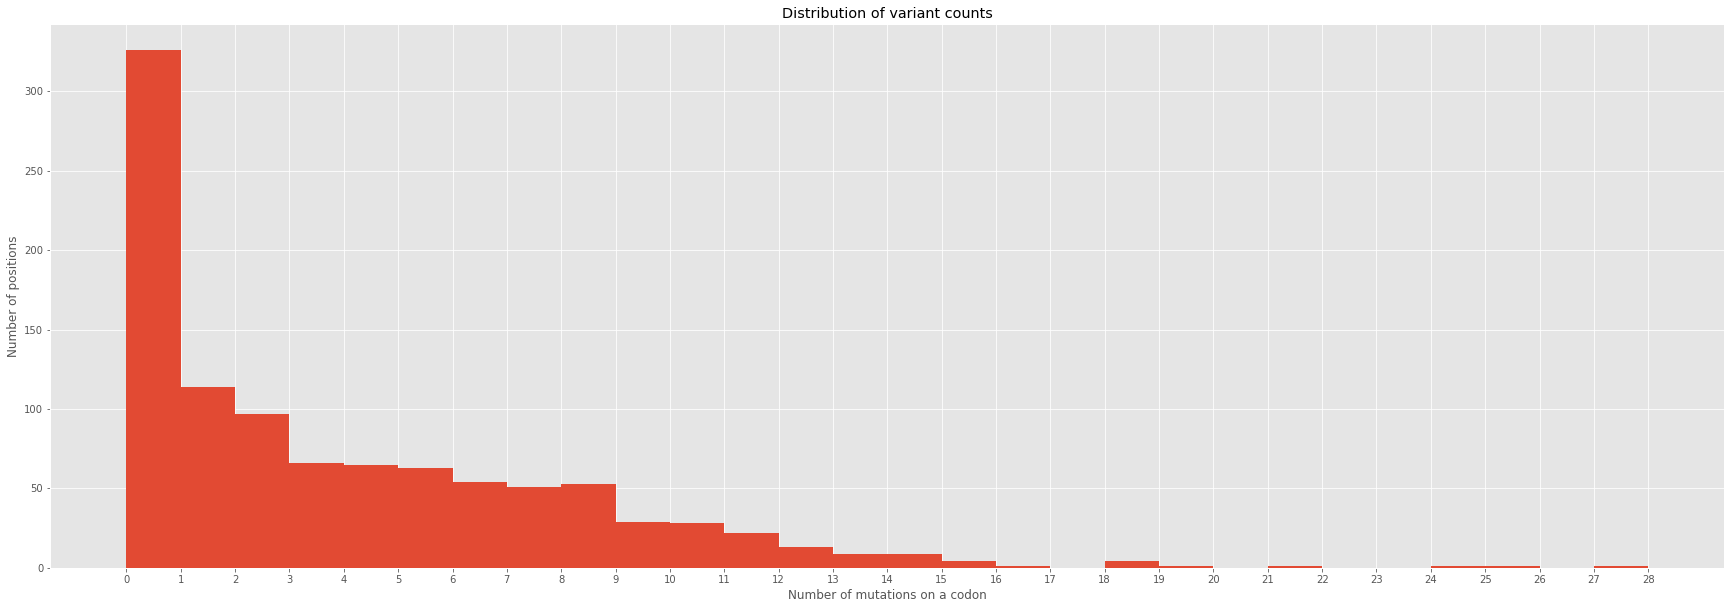

In [85]:
pyplot.hist(x["Count"], bins = range(0, int(max(x["Count"]))))
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.title("Distribution of variant counts")
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Number of positions")
pyplot.show()

Next we divide the variant counts based on the structural elements.

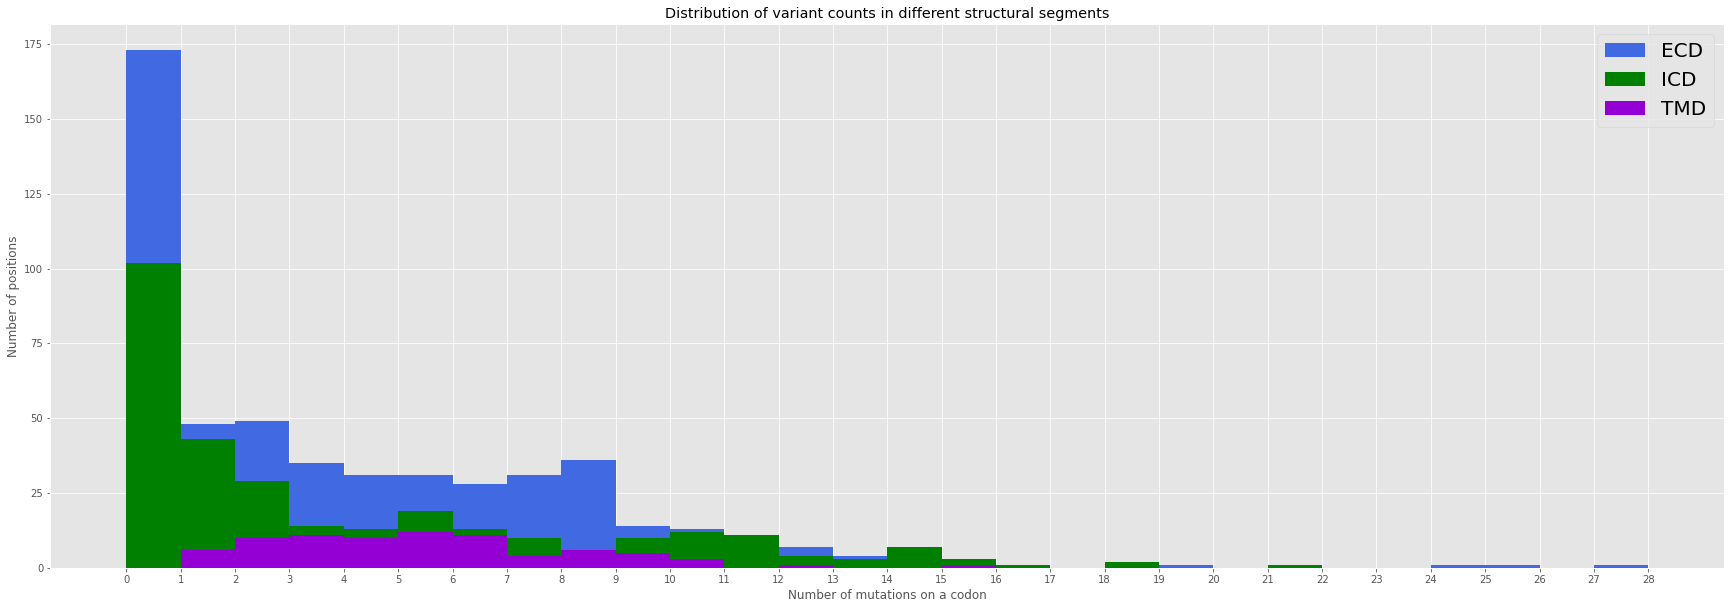

In [86]:
pyplot.hist(x["Count"][x["Region"] == "ECD"], bins = range(0, int(max(x["Count"]))), color="royalblue", lw=0, label="ECD")
pyplot.hist(x["Count"][x["Region"] == "ICD"], bins = range(0, int(max(x["Count"]))), color="green", lw=0, label="ICD")
pyplot.hist(x["Count"][x["Region"].isin(("TM1", "TM2", "TM3", "TM4"))], bins = range(0, int(max(x["Count"]))), color="darkviolet", lw=0, label="TMD")
pyplot.title("Distribution of variant counts in different structural segments")
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Number of positions")
pyplot.legend(prop={"size": 20})
pyplot.show()

We normalize to the length of the segments and produce separate histograms for different structural elements.

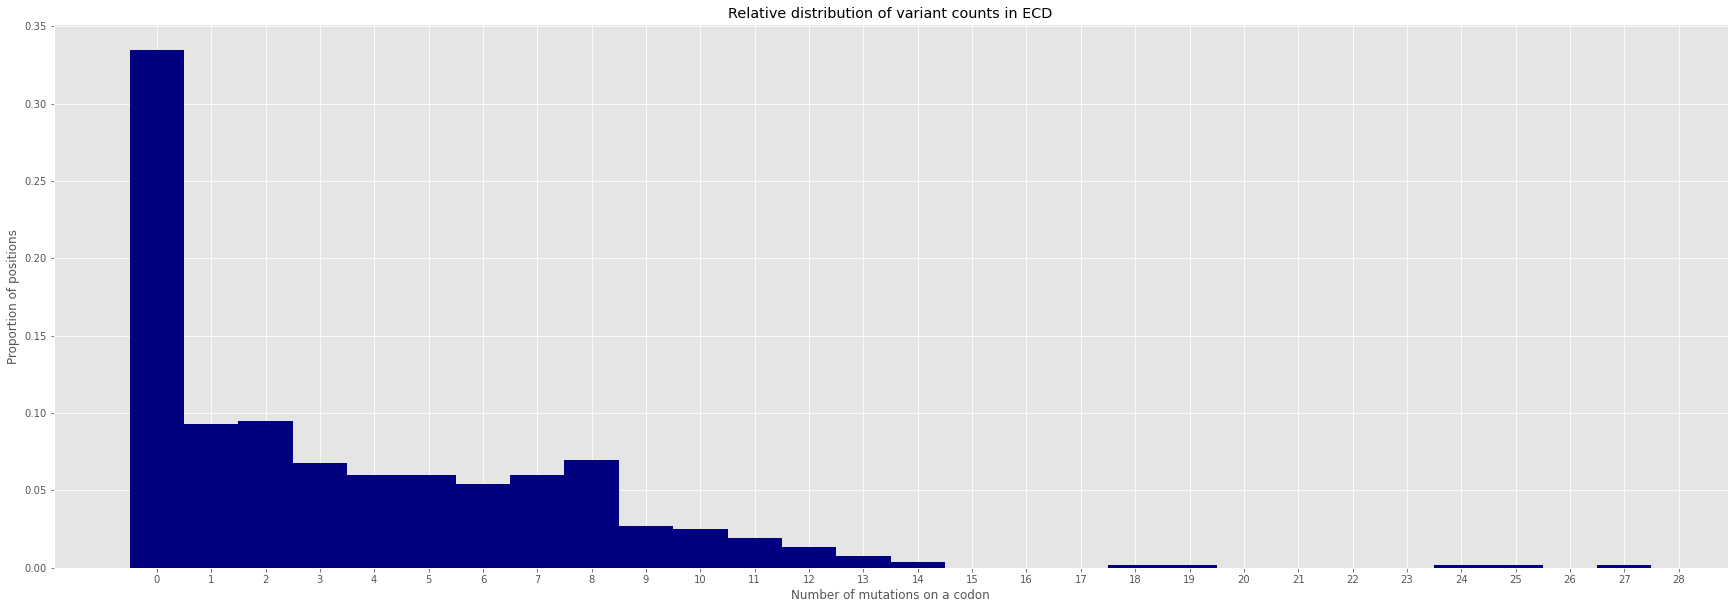

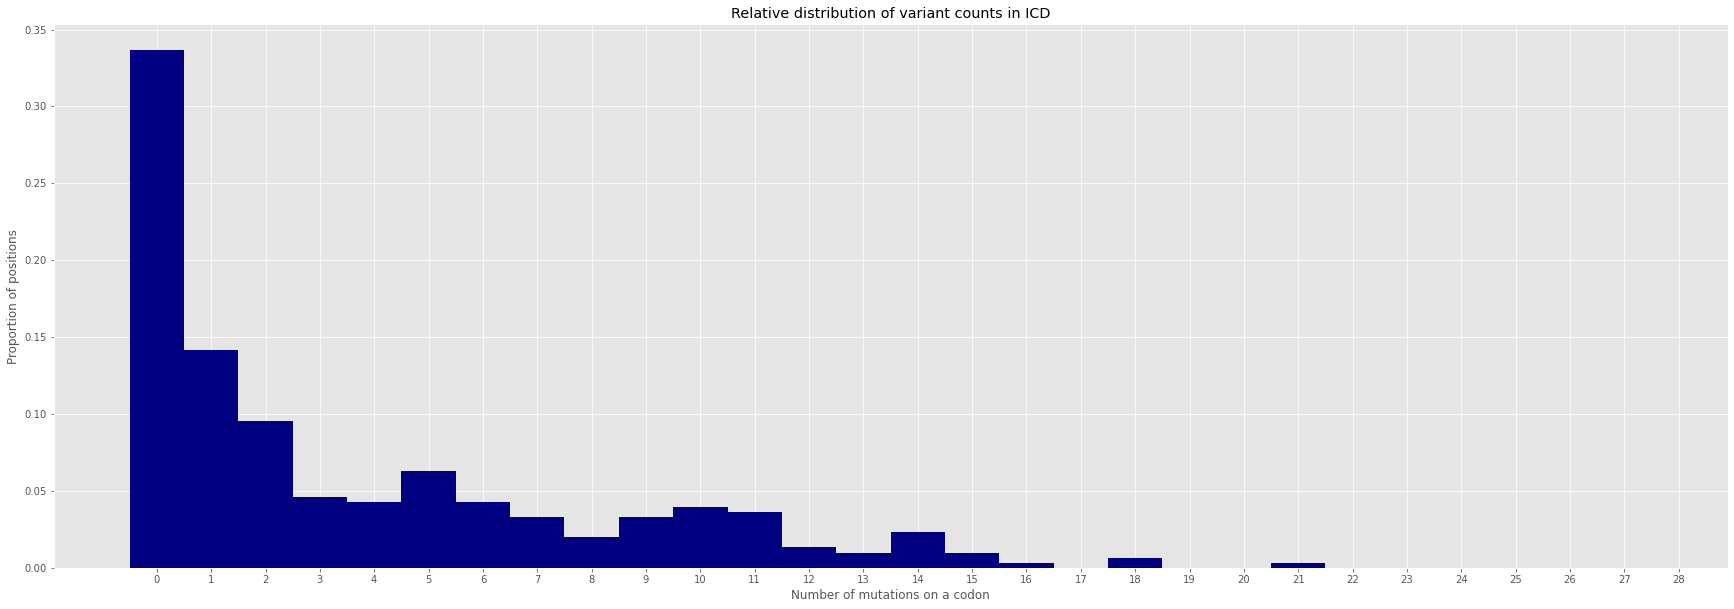

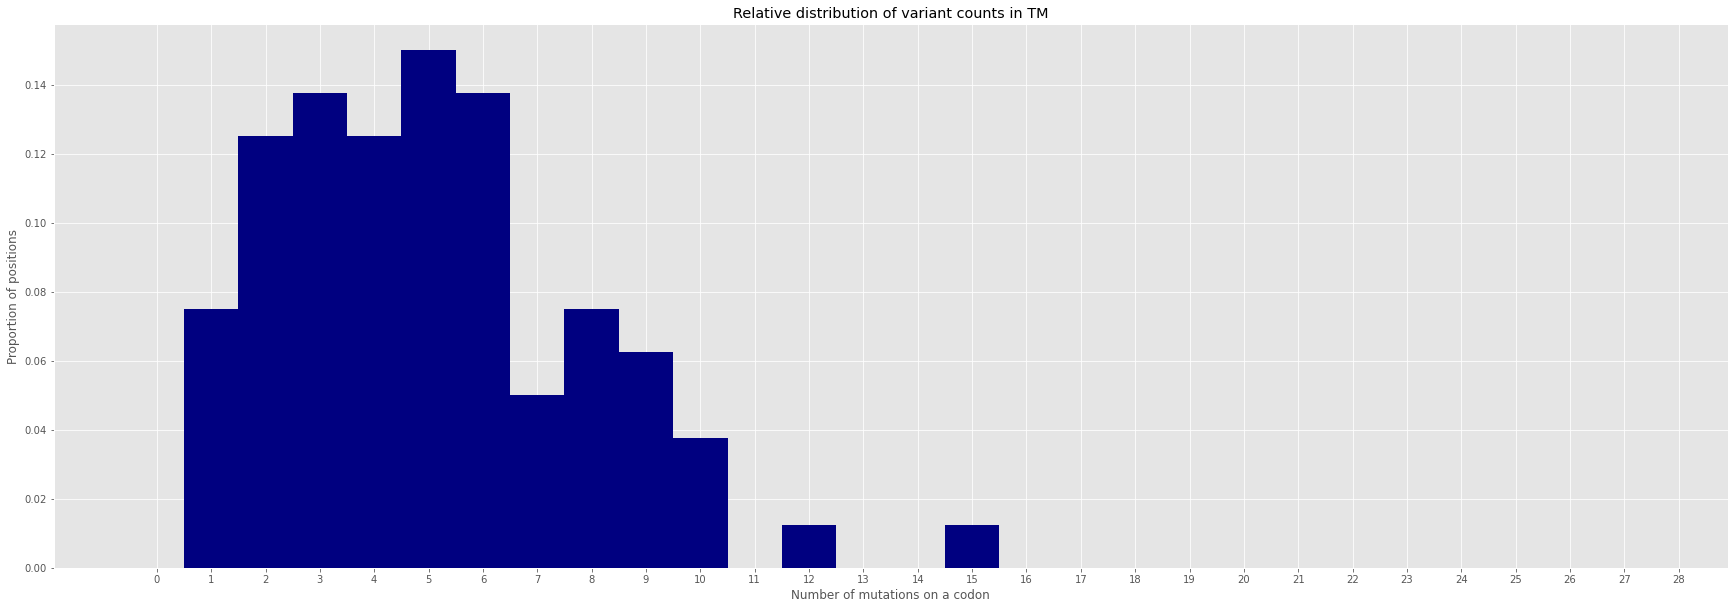

In [88]:
for y in (("ECD",), ("ICD",), ("TM1", "TM2", "TM3", "TM4")):
    pyplot.hist(x["Count"][x["Region"].isin(y)], bins = range(0, int(max(x["Count"]))), color="navy", lw=0, density=True, align="left")
    pyplot.xticks(range(0, int(max(x["Count"]))))
    pyplot.title(f"Relative distribution of variant counts in {y[0].split('1')[0]}")
    pyplot.xlabel(f"Number of mutations on a codon")
    pyplot.ylabel("Proportion of positions")
    pyplot.show()

## Looking at the binding sites

We have the annotation for different binding sites inside a csv file. We have each position in the binding sites linked to three different sequences. For our purpose we will use GABRA1 from AlphaFold. This sequence is taken from UniProt and so we are sure we have it in our reference alignment.

In [89]:
binding_sites = pandas.read_csv("Binding_sites_numbering.csv")
binding_sites

,BS,GABRA1_Alphafold,6X40_D,5VDH_D
0,1 (AM_3607),D54,D27,D25
1,1 (AM_3607),N55,N28,A26
2,1 (AM_3607),R56,R29,R27
3,1 (AM_3607),L57,L30,I28
4,1 (AM_3607),R58,R31,R29
...,...,...,...,...
131,7 (Pore),L291,L264,L261
132,7 (Pore),T292,T265,T263
133,7 (Pore),T295,T268,T265
134,7 (Pore),I298,I271,S268


First we need to separate the amino acid abbreviation from the numbering. We store these into separate columns.

In [90]:
binding_sites["AA"] = binding_sites["GABRA1_Alphafold"].str[0]
binding_sites["AA Number"] = binding_sites["GABRA1_Alphafold"].str[1:]

Next we want to convert the number into the number in the reference sequence. First we couble check if the function accepts our input. Then we perform the search for each row in the table. 

In [94]:
binding_sites["AA Referenced"] = binding_sites.apply(lambda y: ali_class.find_reference("GABRA1", y["AA"], int(y["AA Number"])), axis=1)

We check next how many amino acids are unassigned. We see there are none.

In [95]:
sum(binding_sites["AA Referenced"] == -1)

0

## Checking TMD binding sites

We first check which binding sites we have the annotation for. As we can see this is the case for 7 binding sites and the pore forming amino acids.

In [96]:
binding_sites["BS"].unique()

array(['1 (AM_3607)', '2 (BZD/Ortho)', '3 (upperTMD)',
       '3.5 (upperTMD - IVM)', '4 (interface steroid site)',
       '5 (PS Site)', '6 (PTX Site)', '7 (Pore)'], dtype=object)

Of all the binding sites we have the annotation for four TMD sites. We will first put them and the pore into a list for easier handling later on.

In [148]:
bs_interest = ["3 (upperTMD)", "3.5 (upperTMD - IVM)", "4 (interface steroid site)", "5 (PS Site)", "7 (Pore)"]


## Heatmaps for all binding sites of interest

For every binding site of interest (plus pore) we will create and save first the heatmap of sum of minor allele count per 100,000 on each binding site position.
Then we will plot heatmaps with number of variants for each gene on each of the binding site positions. We will also save all the heatmaps.

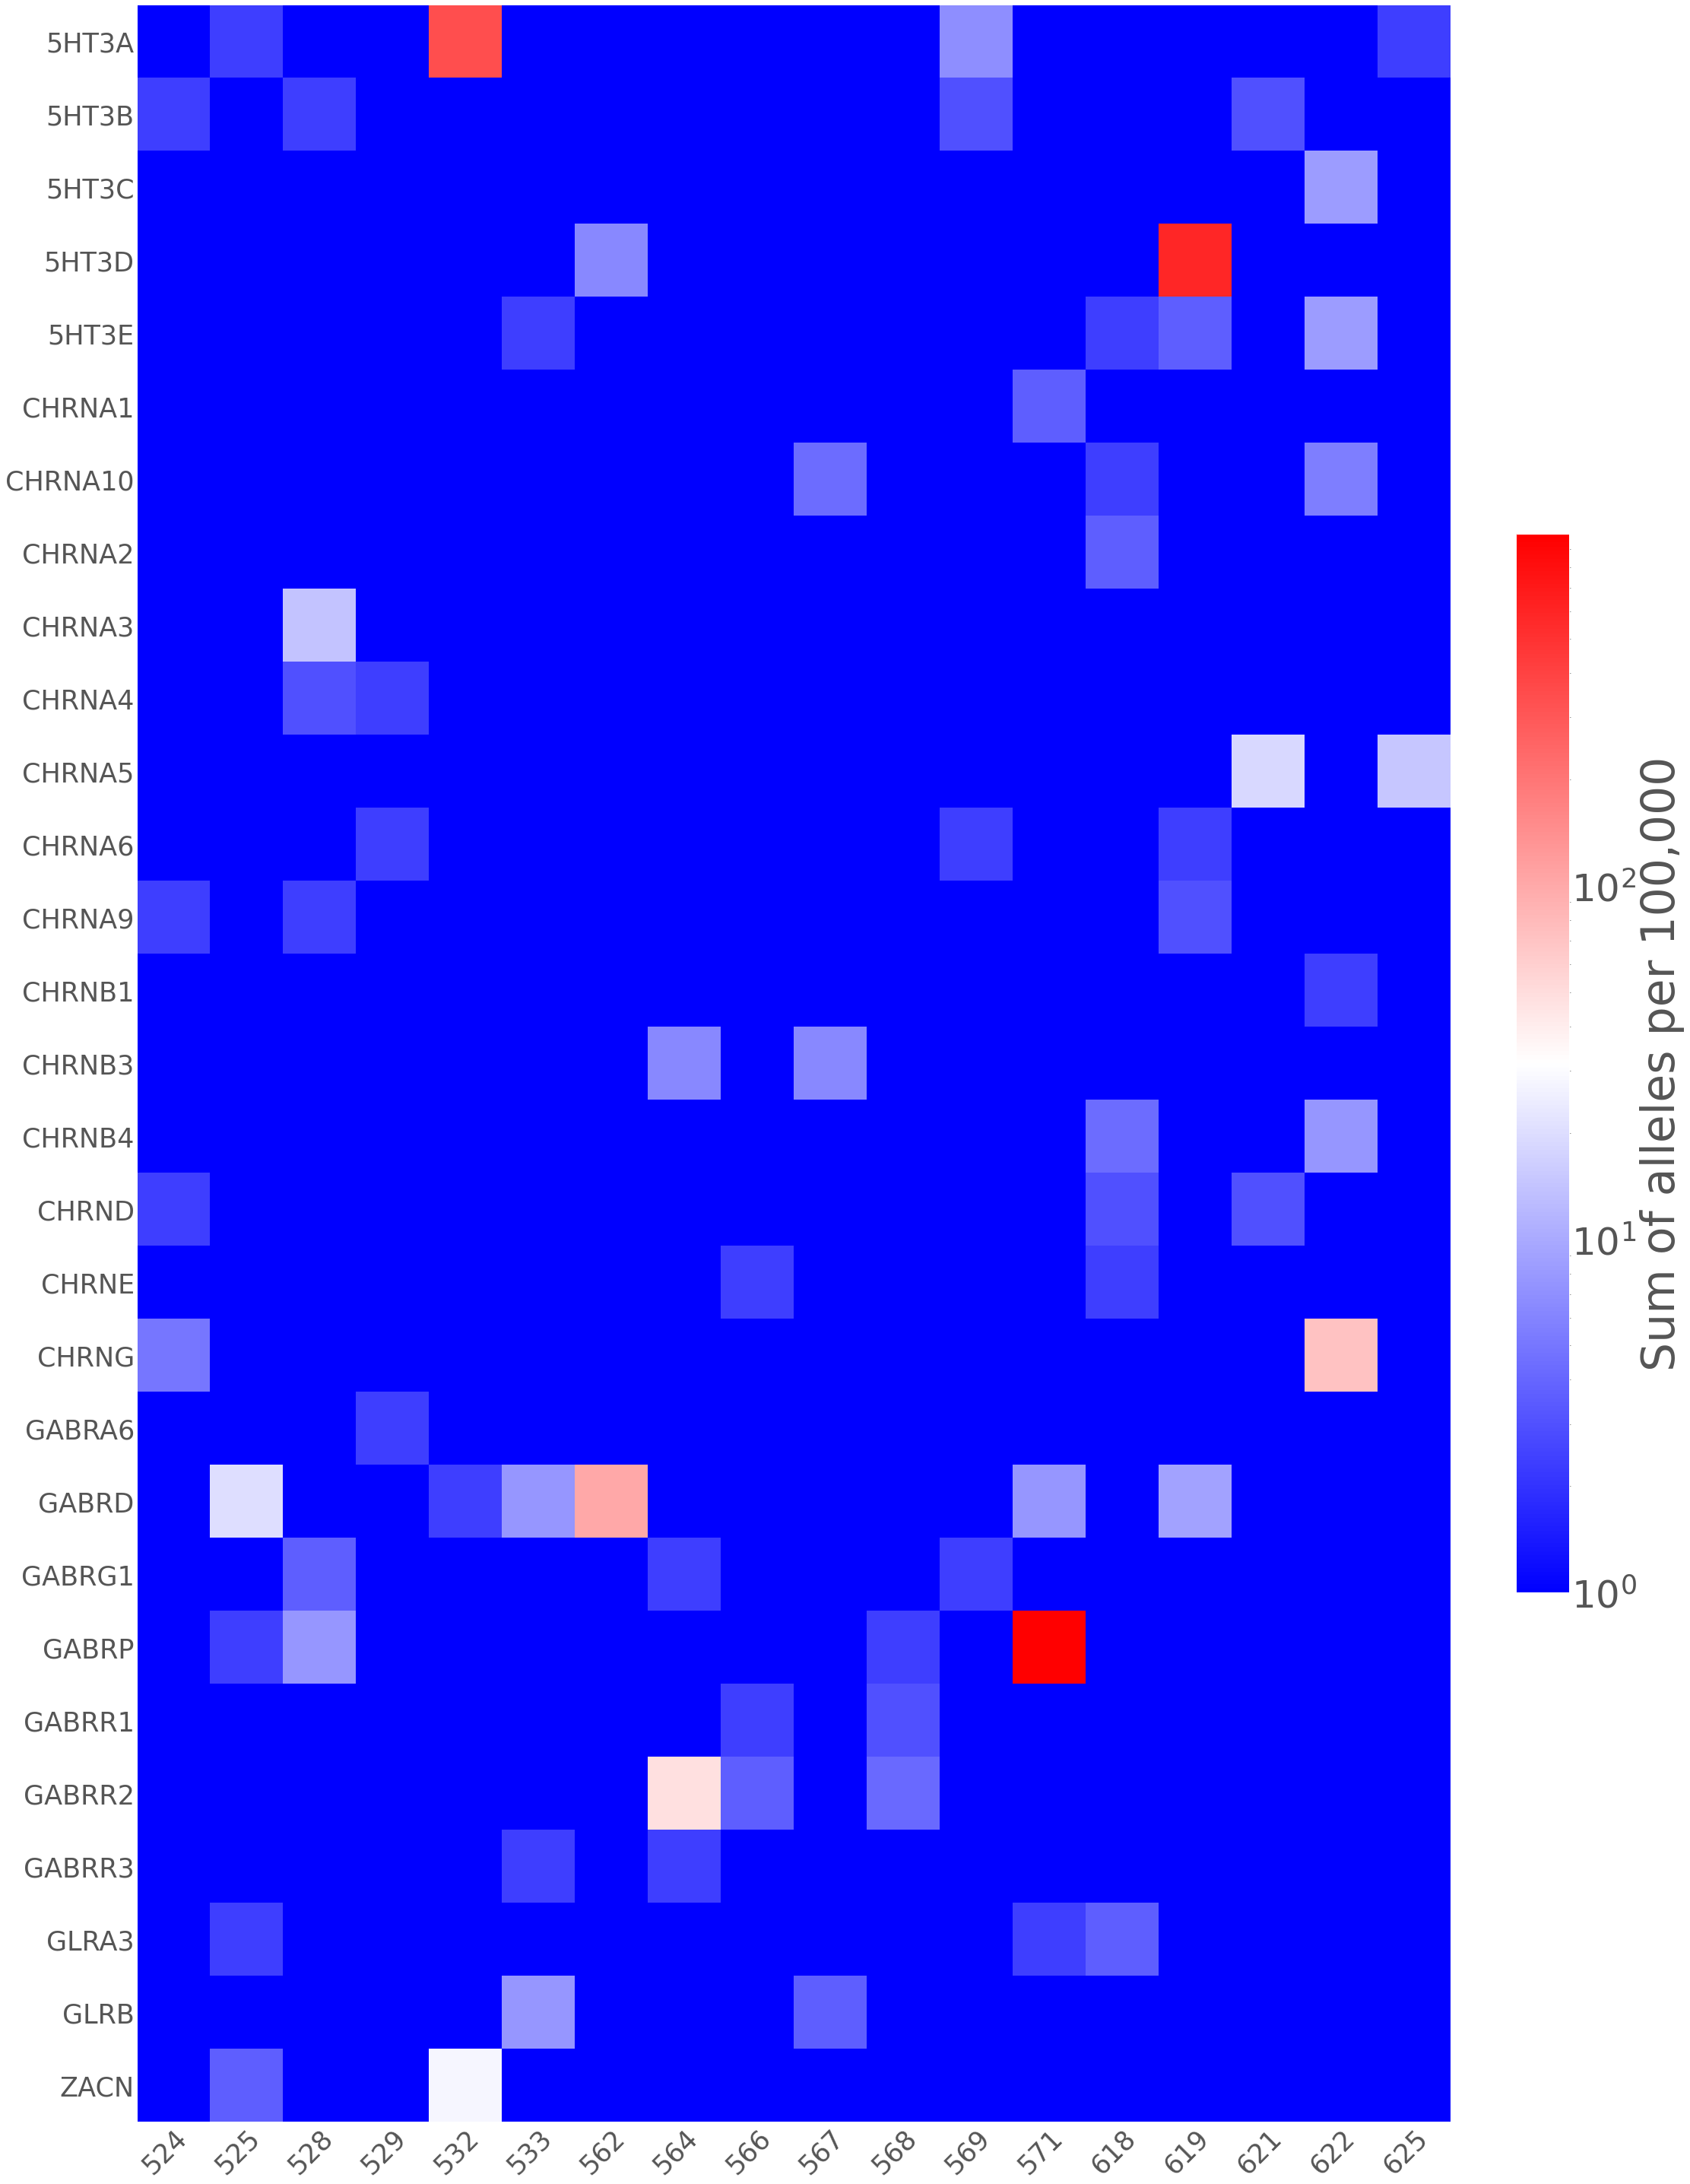

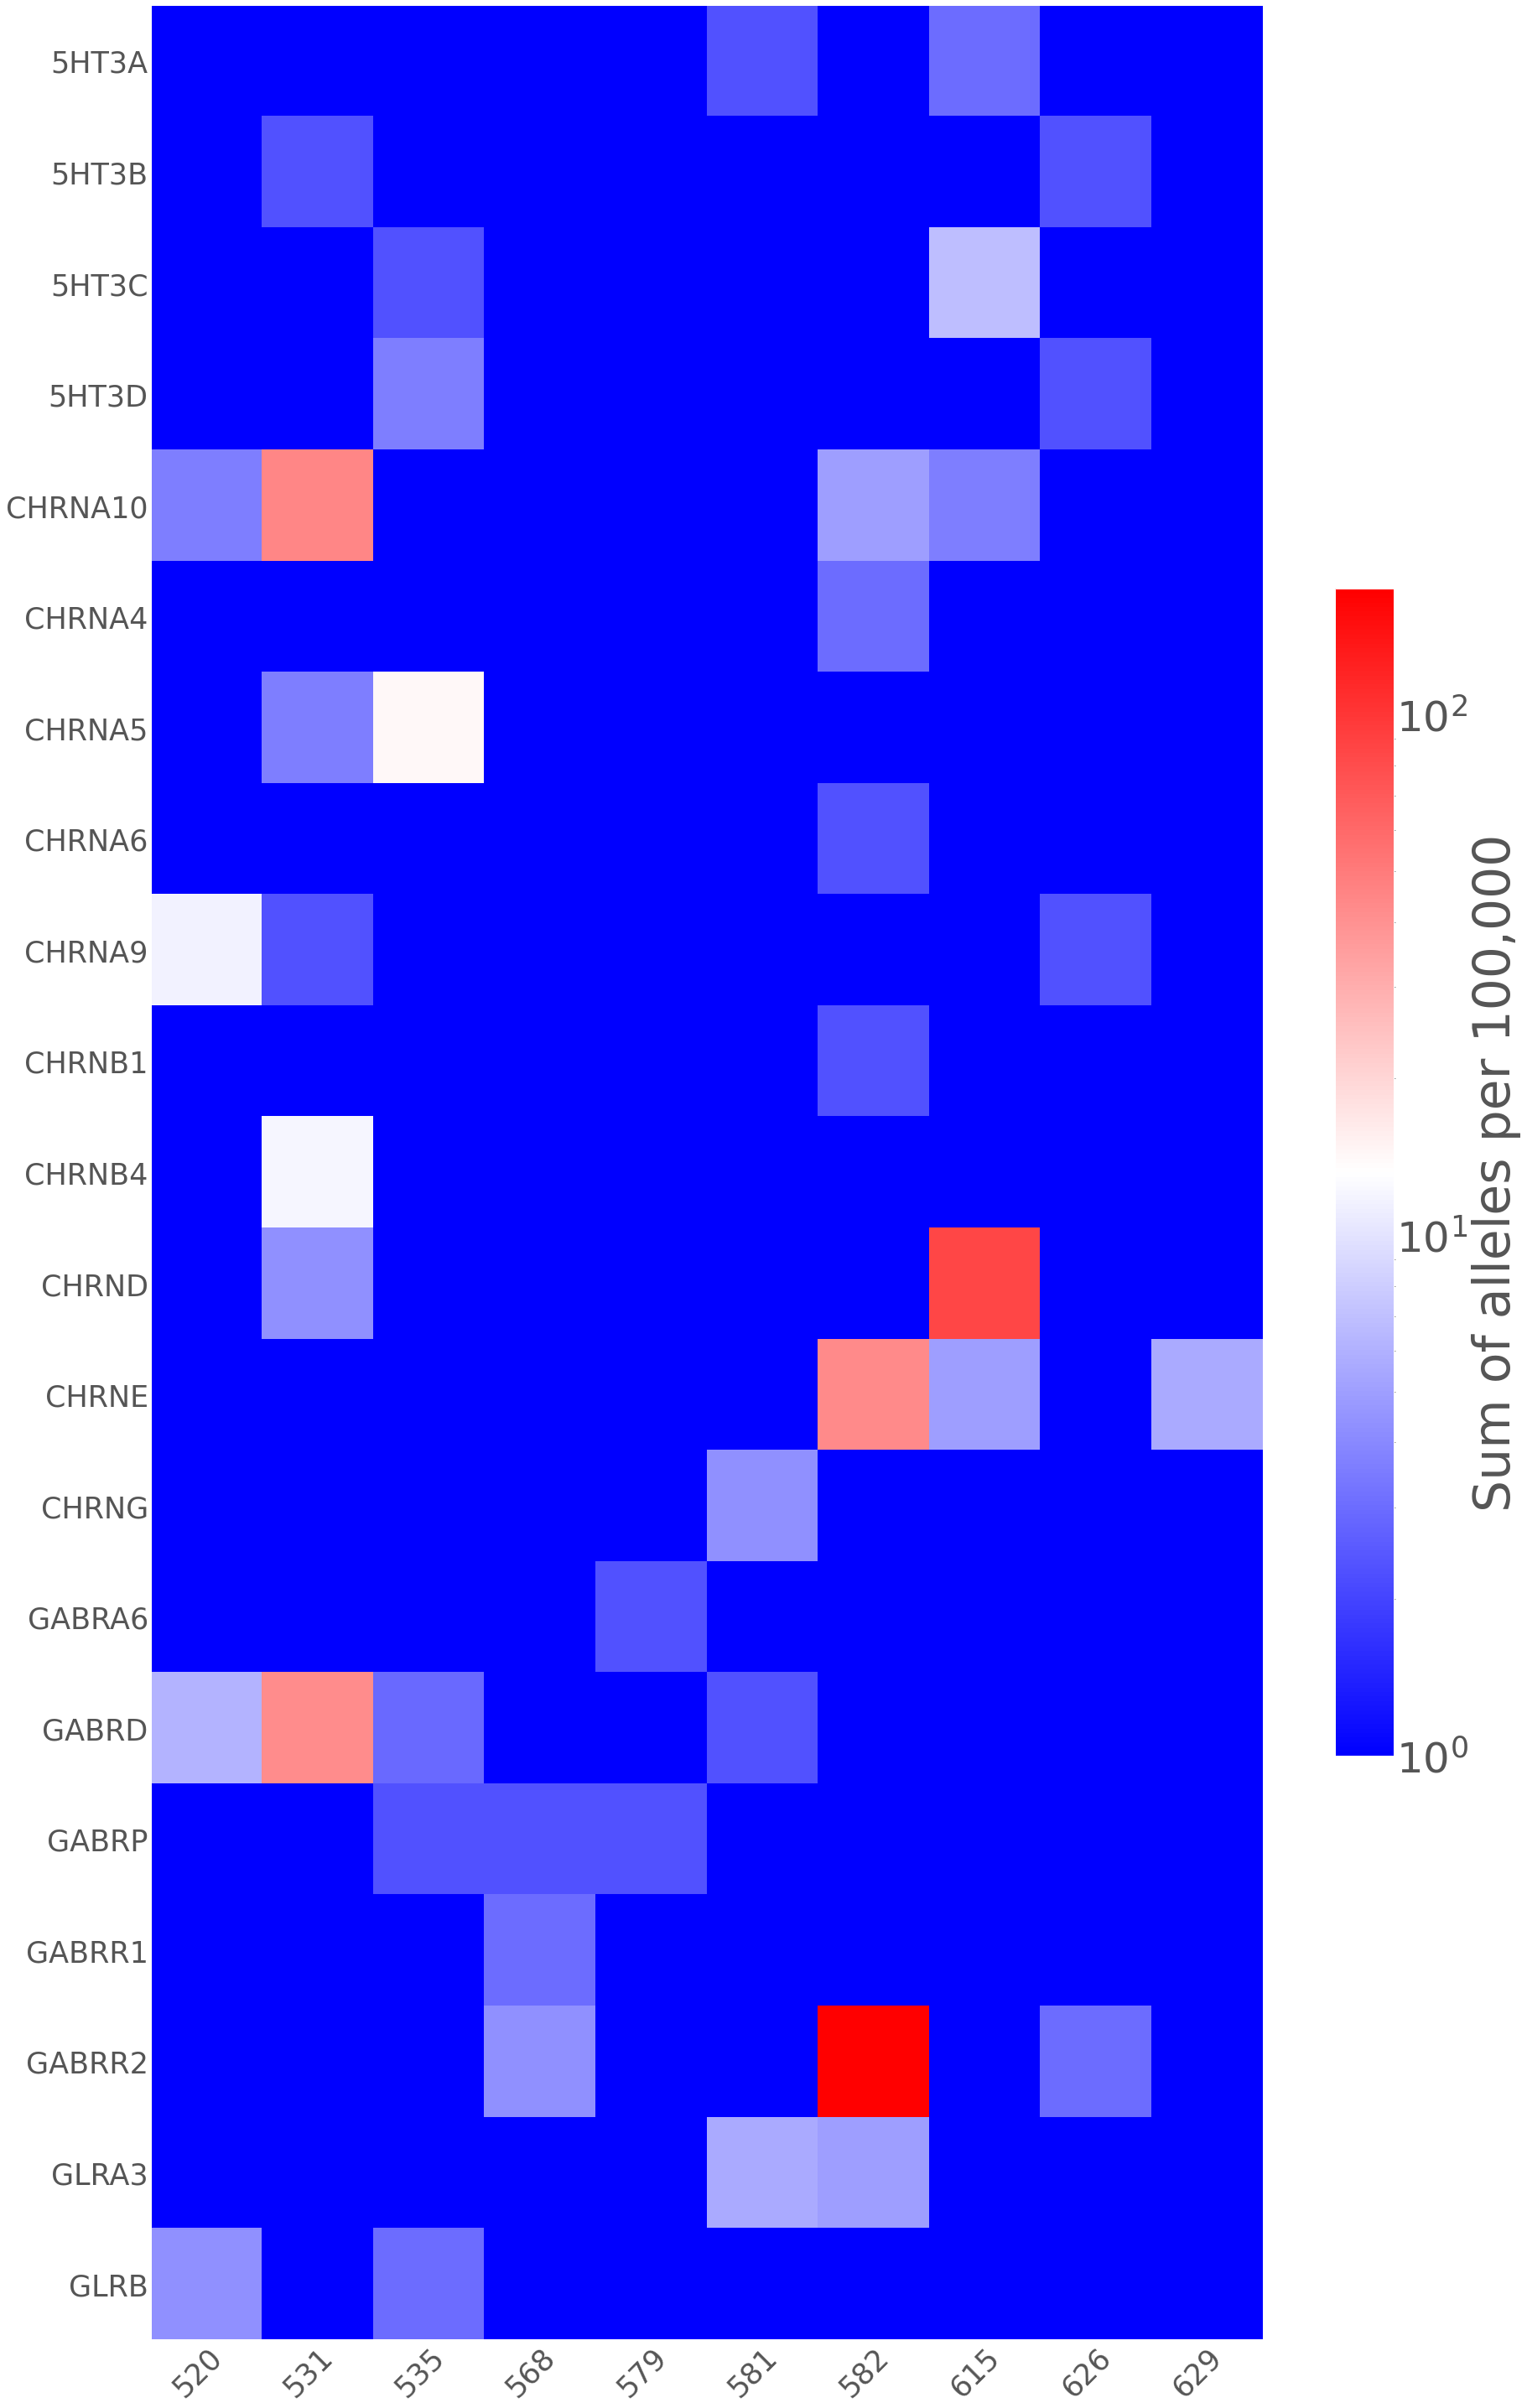

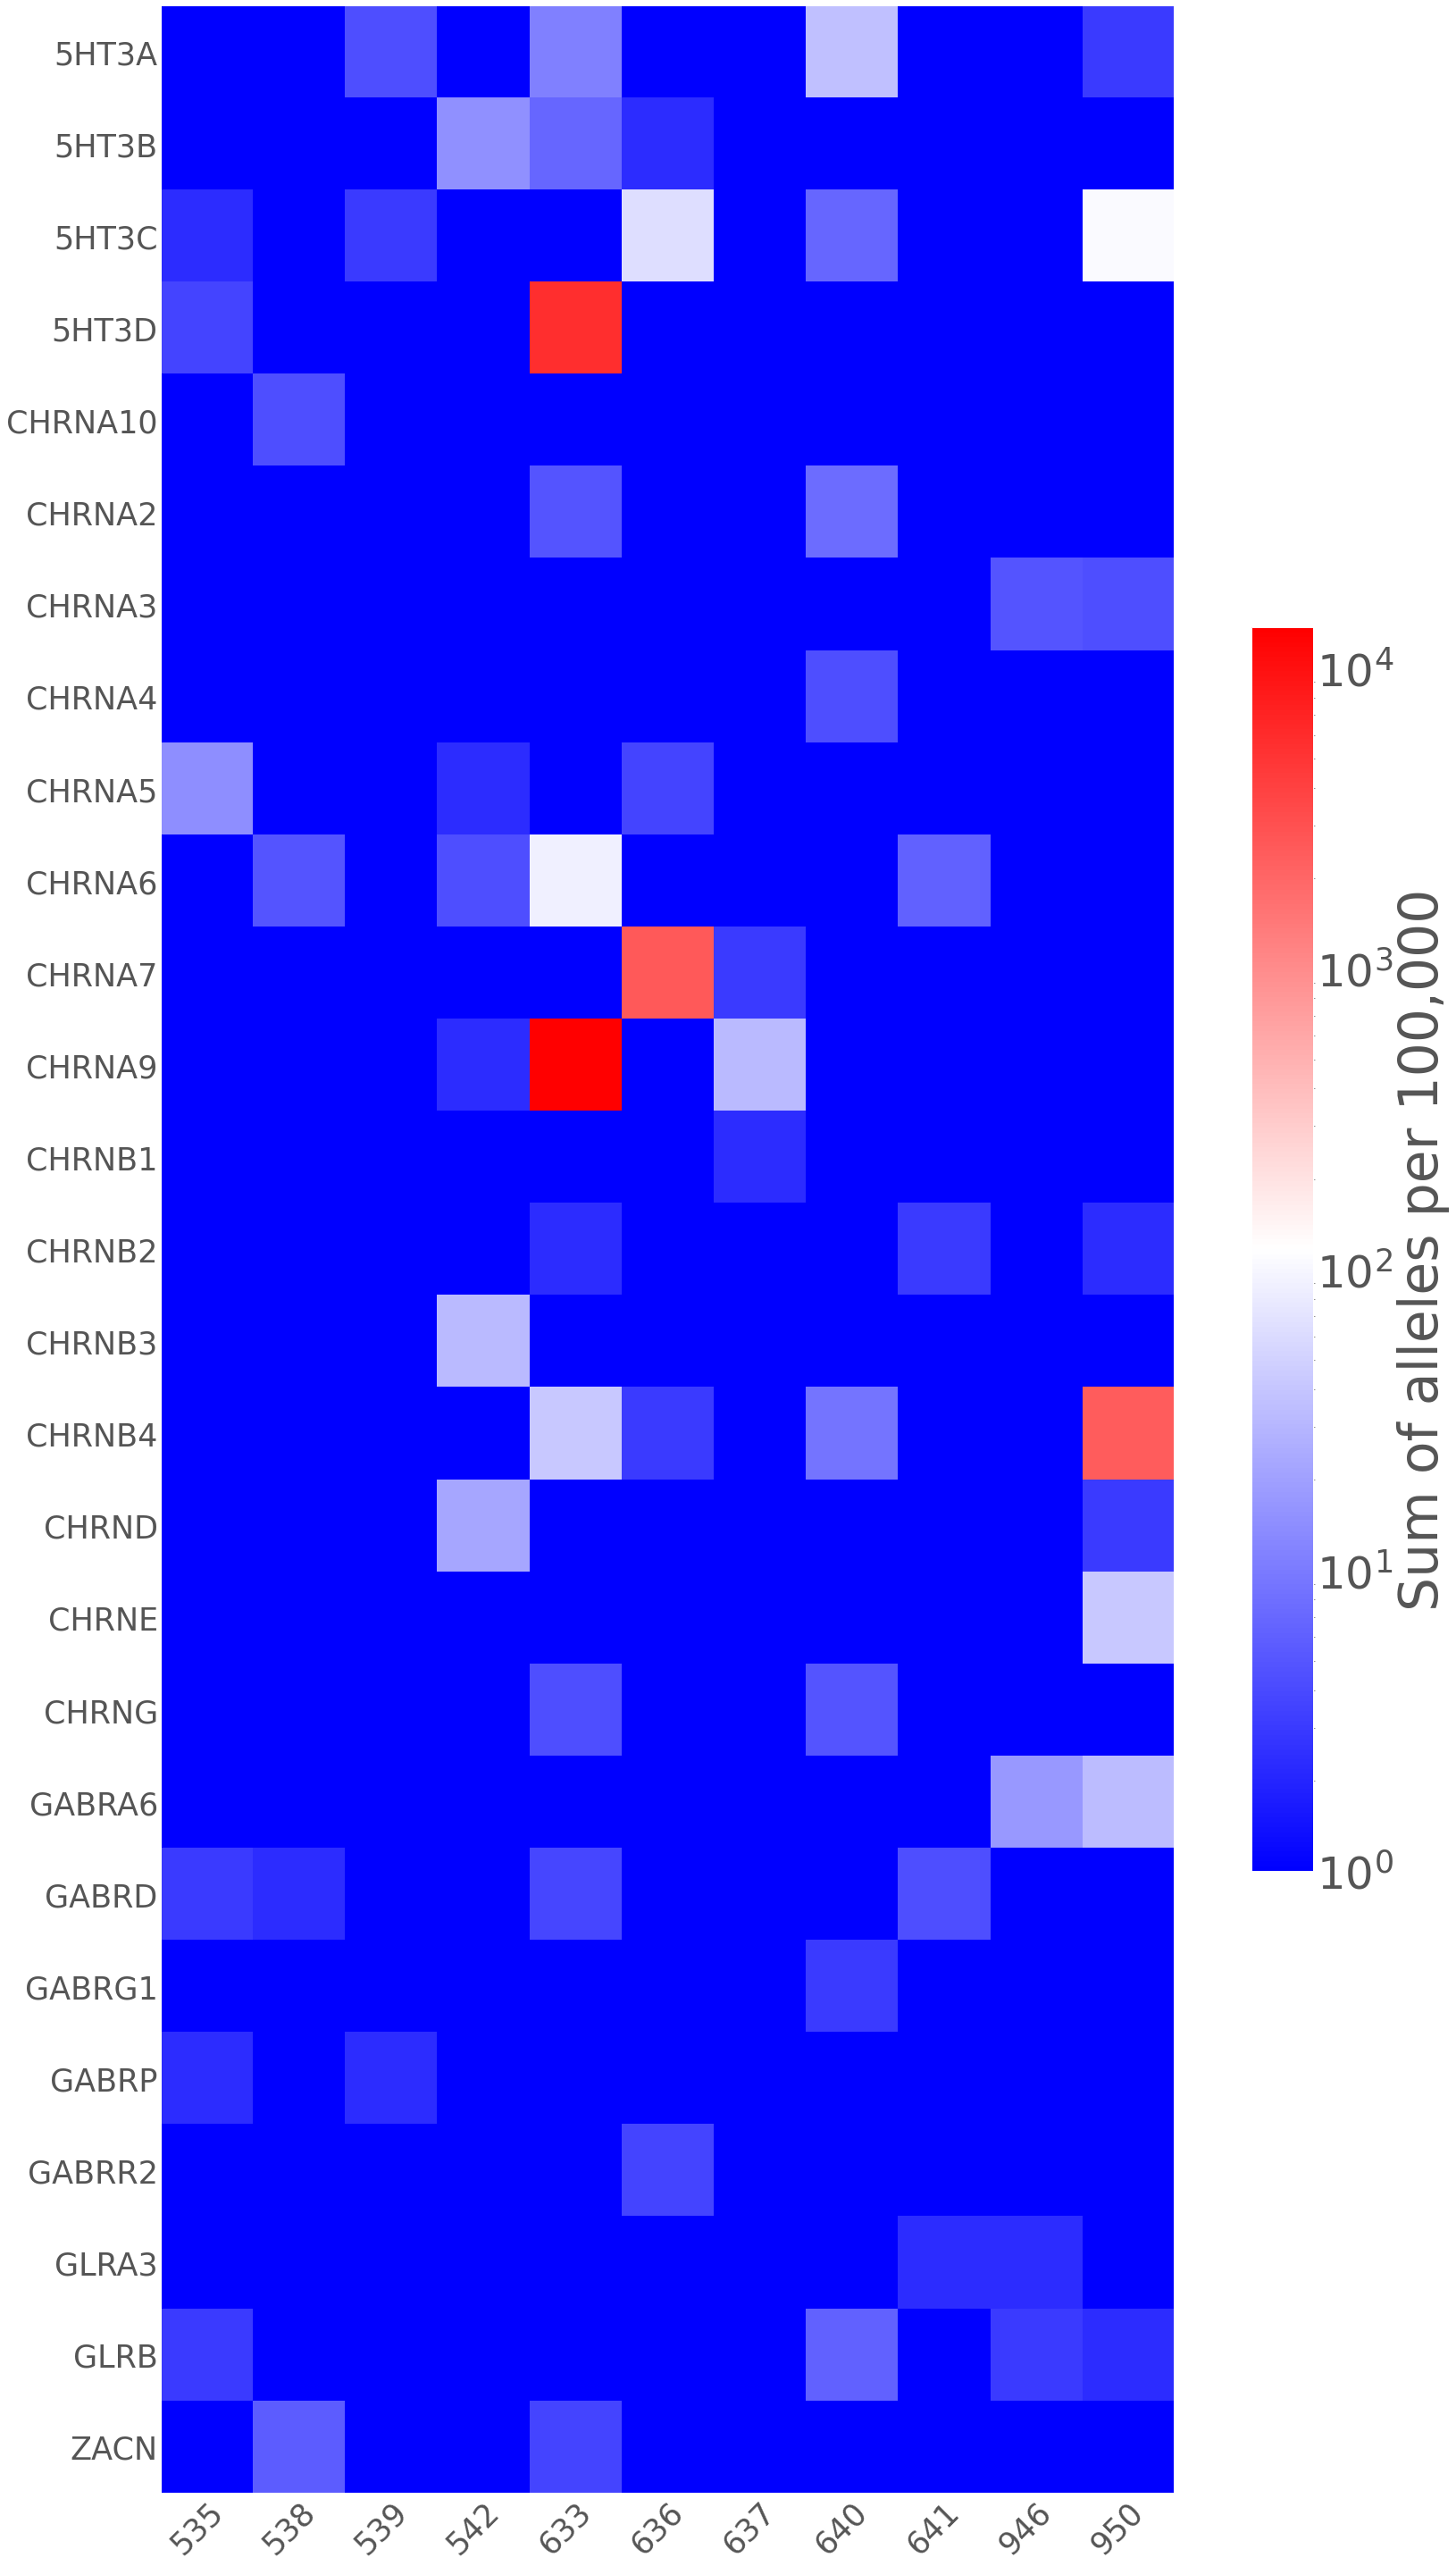

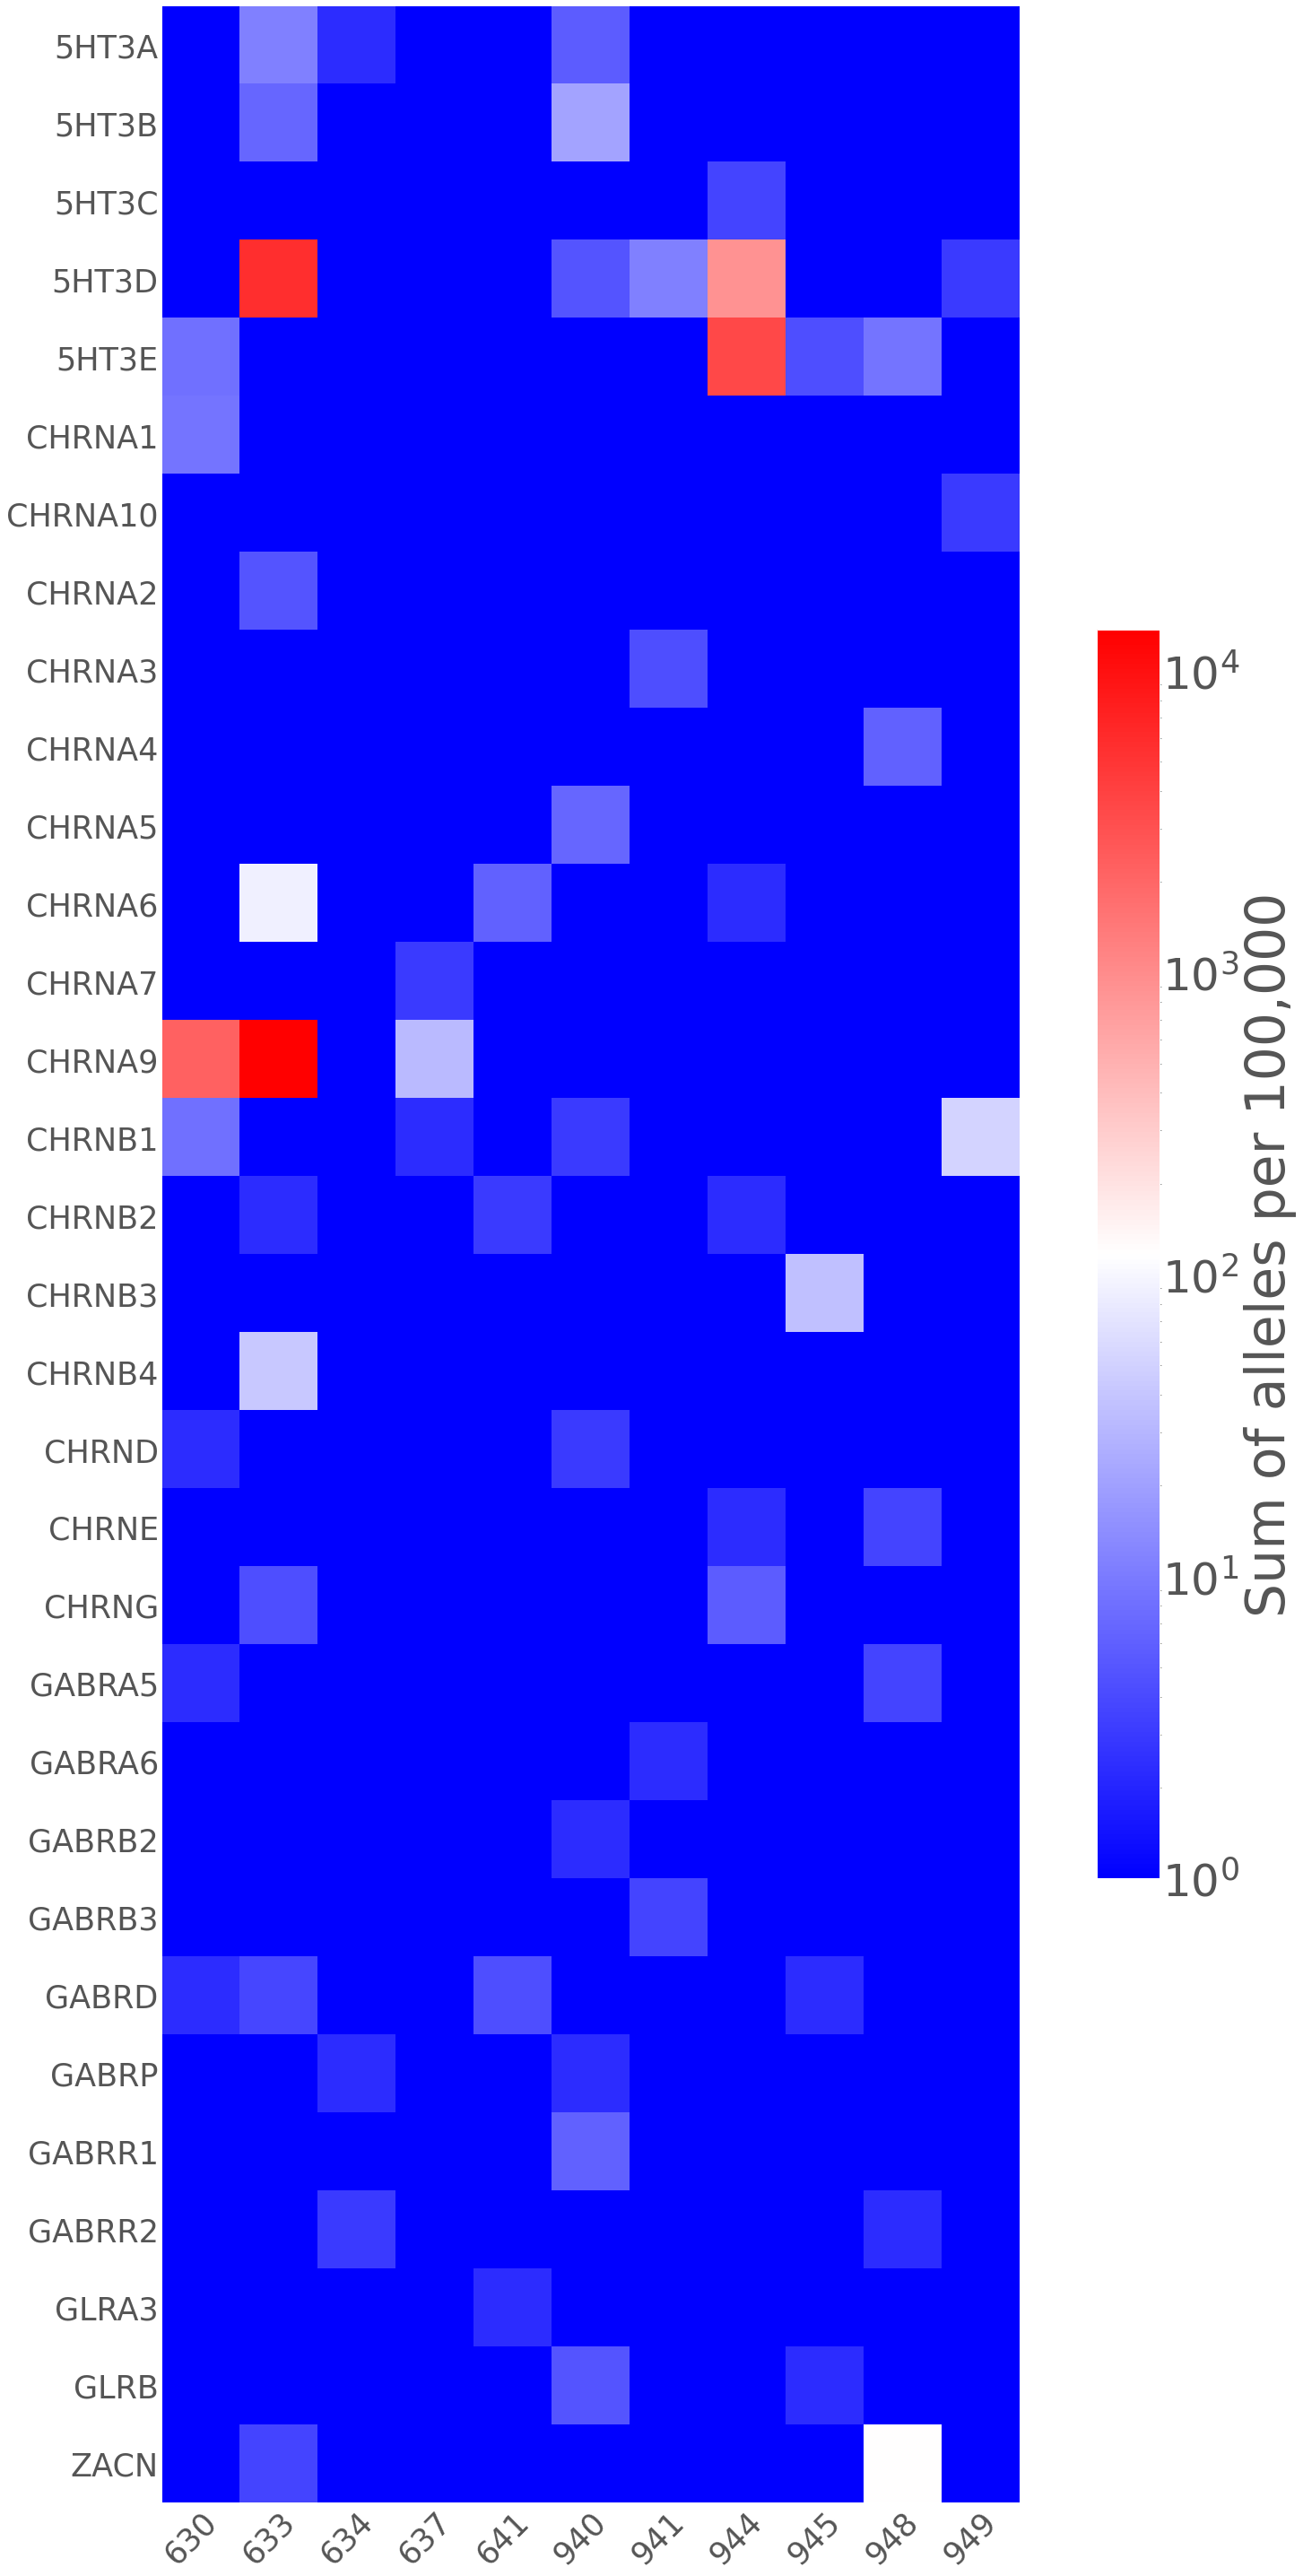

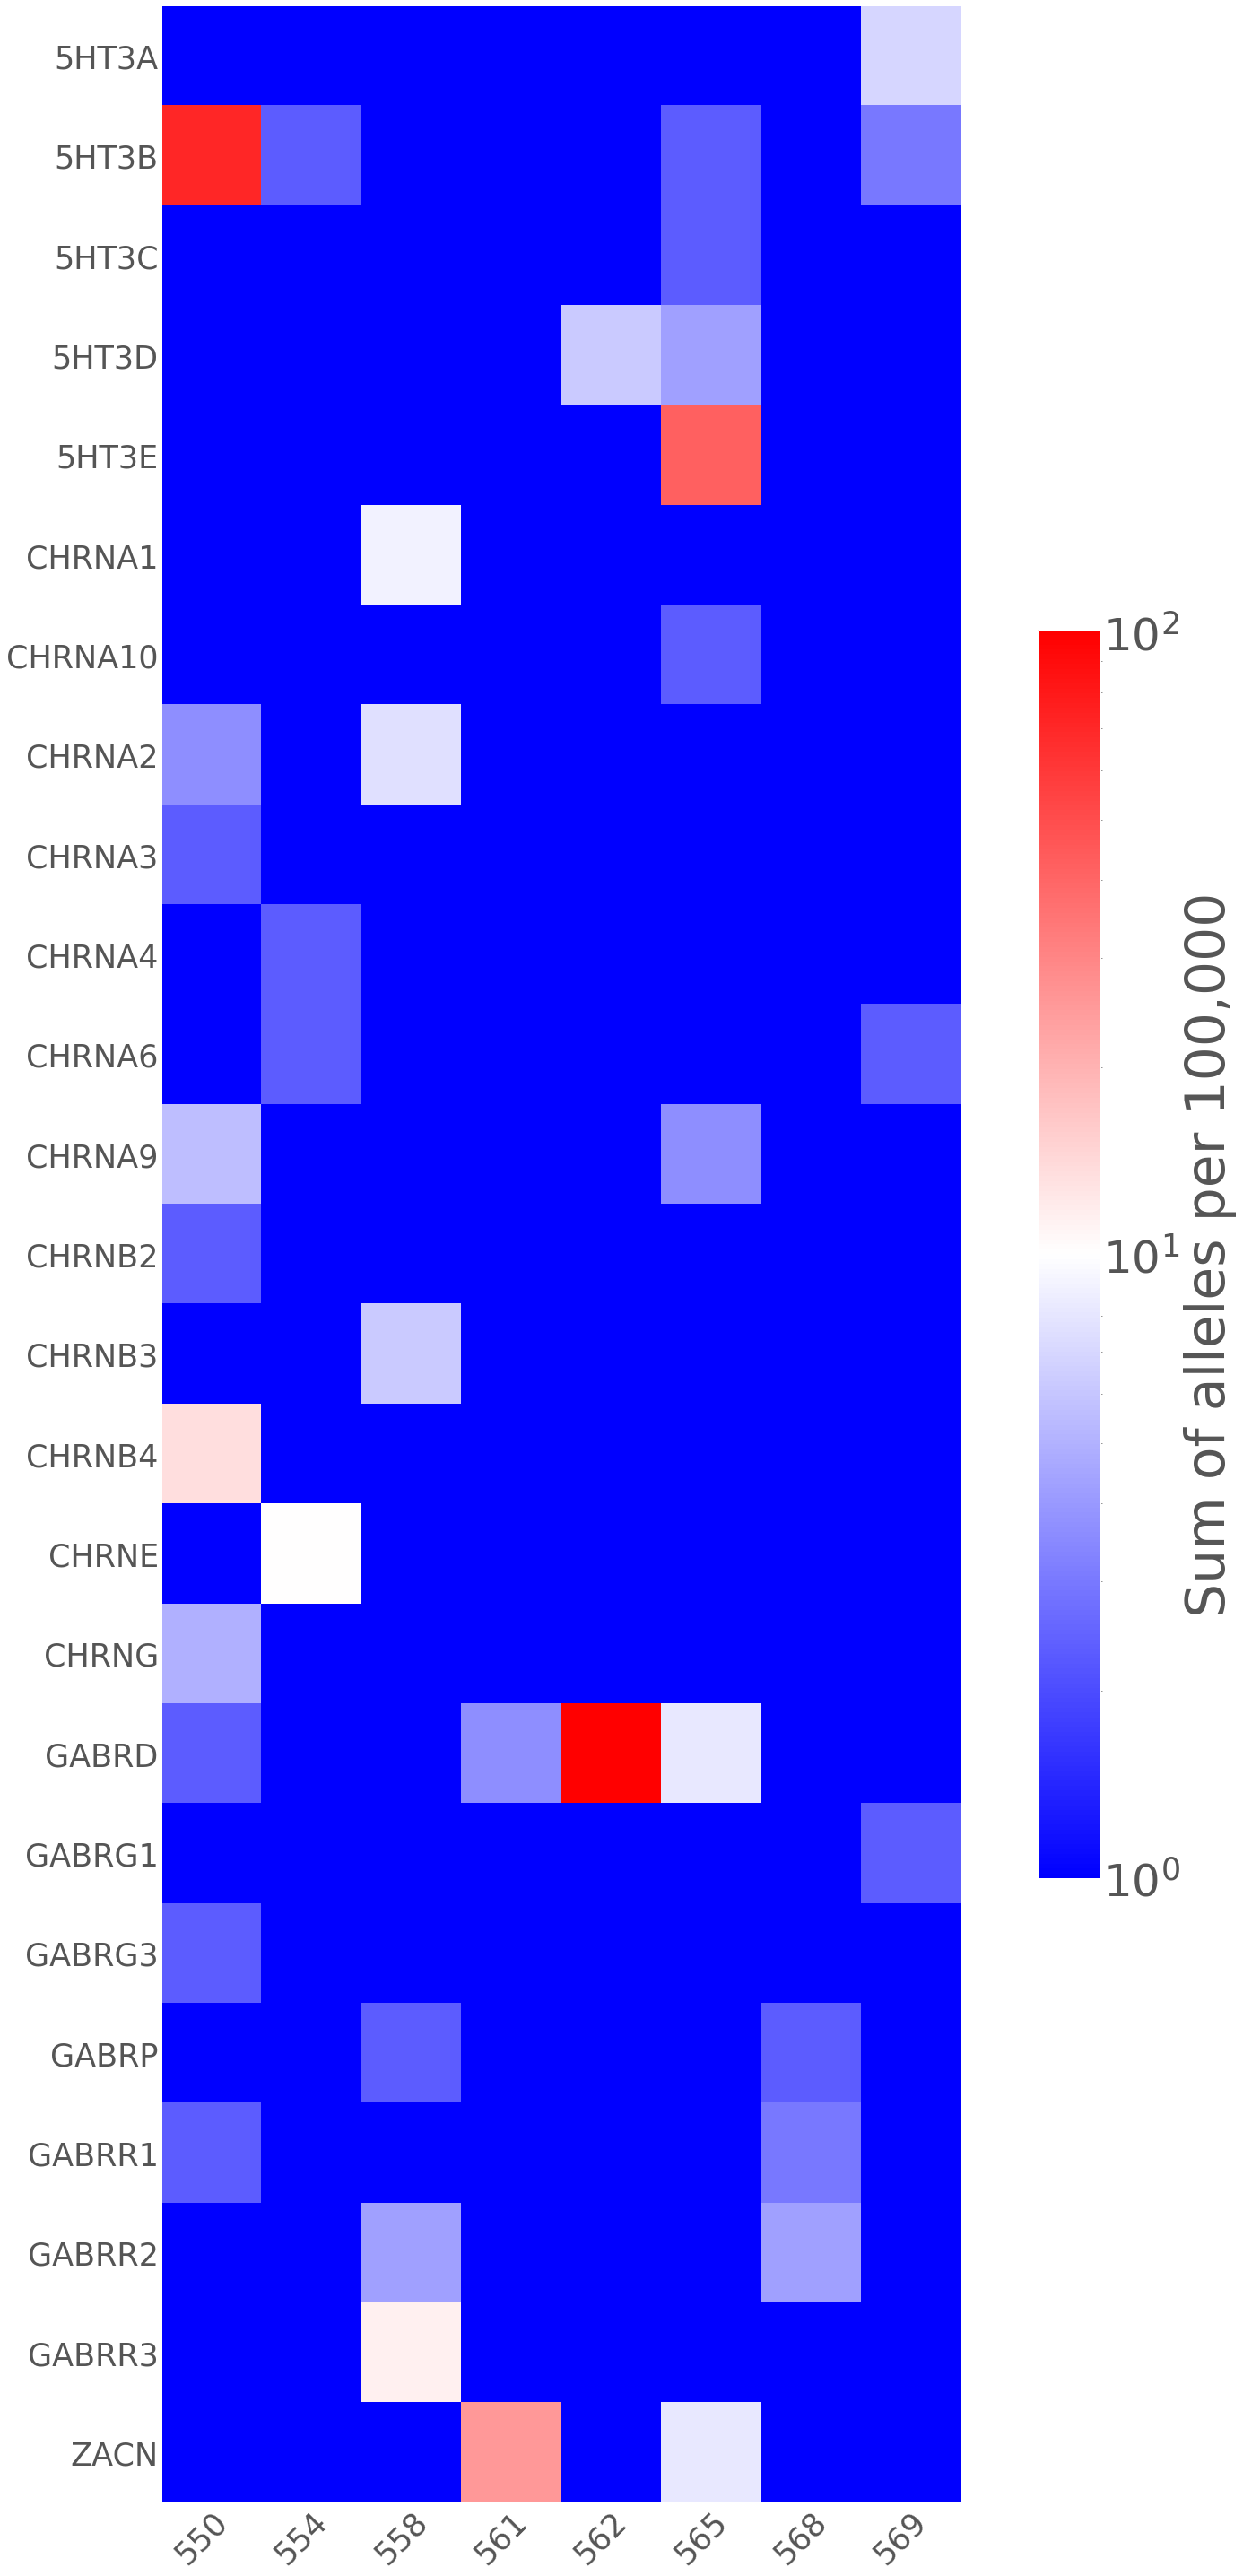

In [149]:
def plot_heatmap(data, aacids, genes, bs = "", title=True, save=False):
    pyplot.rcParams["axes.grid"] = False

    matplotlib.rcParams["figure.figsize"] = (120, 40)

    fig, ax = pyplot.subplots()
    im = ax.imshow(data+1, norm=matplotlib.colors.LogNorm(), cmap=pyplot.get_cmap("bwr"), interpolation="nearest")

    cbar = pyplot.colorbar(im, ax=ax, shrink=0.5, pad=0.01)
    cbar.ax.tick_params(labelsize=50, size=0)
    cbar.set_label("Sum of alleles per 100,000", size=60)

    ax.set_xticks(numpy.arange(len(aacids)), labels=[str(aa) for aa in aacids])
    ax.set_yticks(numpy.arange(len(genes)), labels=genes)

    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", size=35)
    pyplot.setp(ax.get_yticklabels(), size=35)
    pyplot.tick_params(axis="both", which="both", length=0)

    if title:
        ax.set_title(bs)

    fig.tight_layout()
    pyplot.show()

    if save:
        fig.savefig(f"Export/Heatmap_{bs}.png", format="png", bbox_inches="tight", dpi=300)

    pyplot.rcParams["axes.grid"] = True

genes = [y for y in ali_class._sequences.keys() if ("_" not in y) and ("." not in y)]
genes = pandas.Series(genes).sort_values(ascending=True, ignore_index=True)

for bs in bs_interest:
    site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs])]

    aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs]
    data = numpy.array([[sum(site_data["Allele Frequency"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)])*100_000 for aa in aacids] for gene in genes])

    retained = data.sum(axis=1) != 0
    plot_heatmap(data[retained, :], aacids, genes[retained], bs, title=False, save=True)

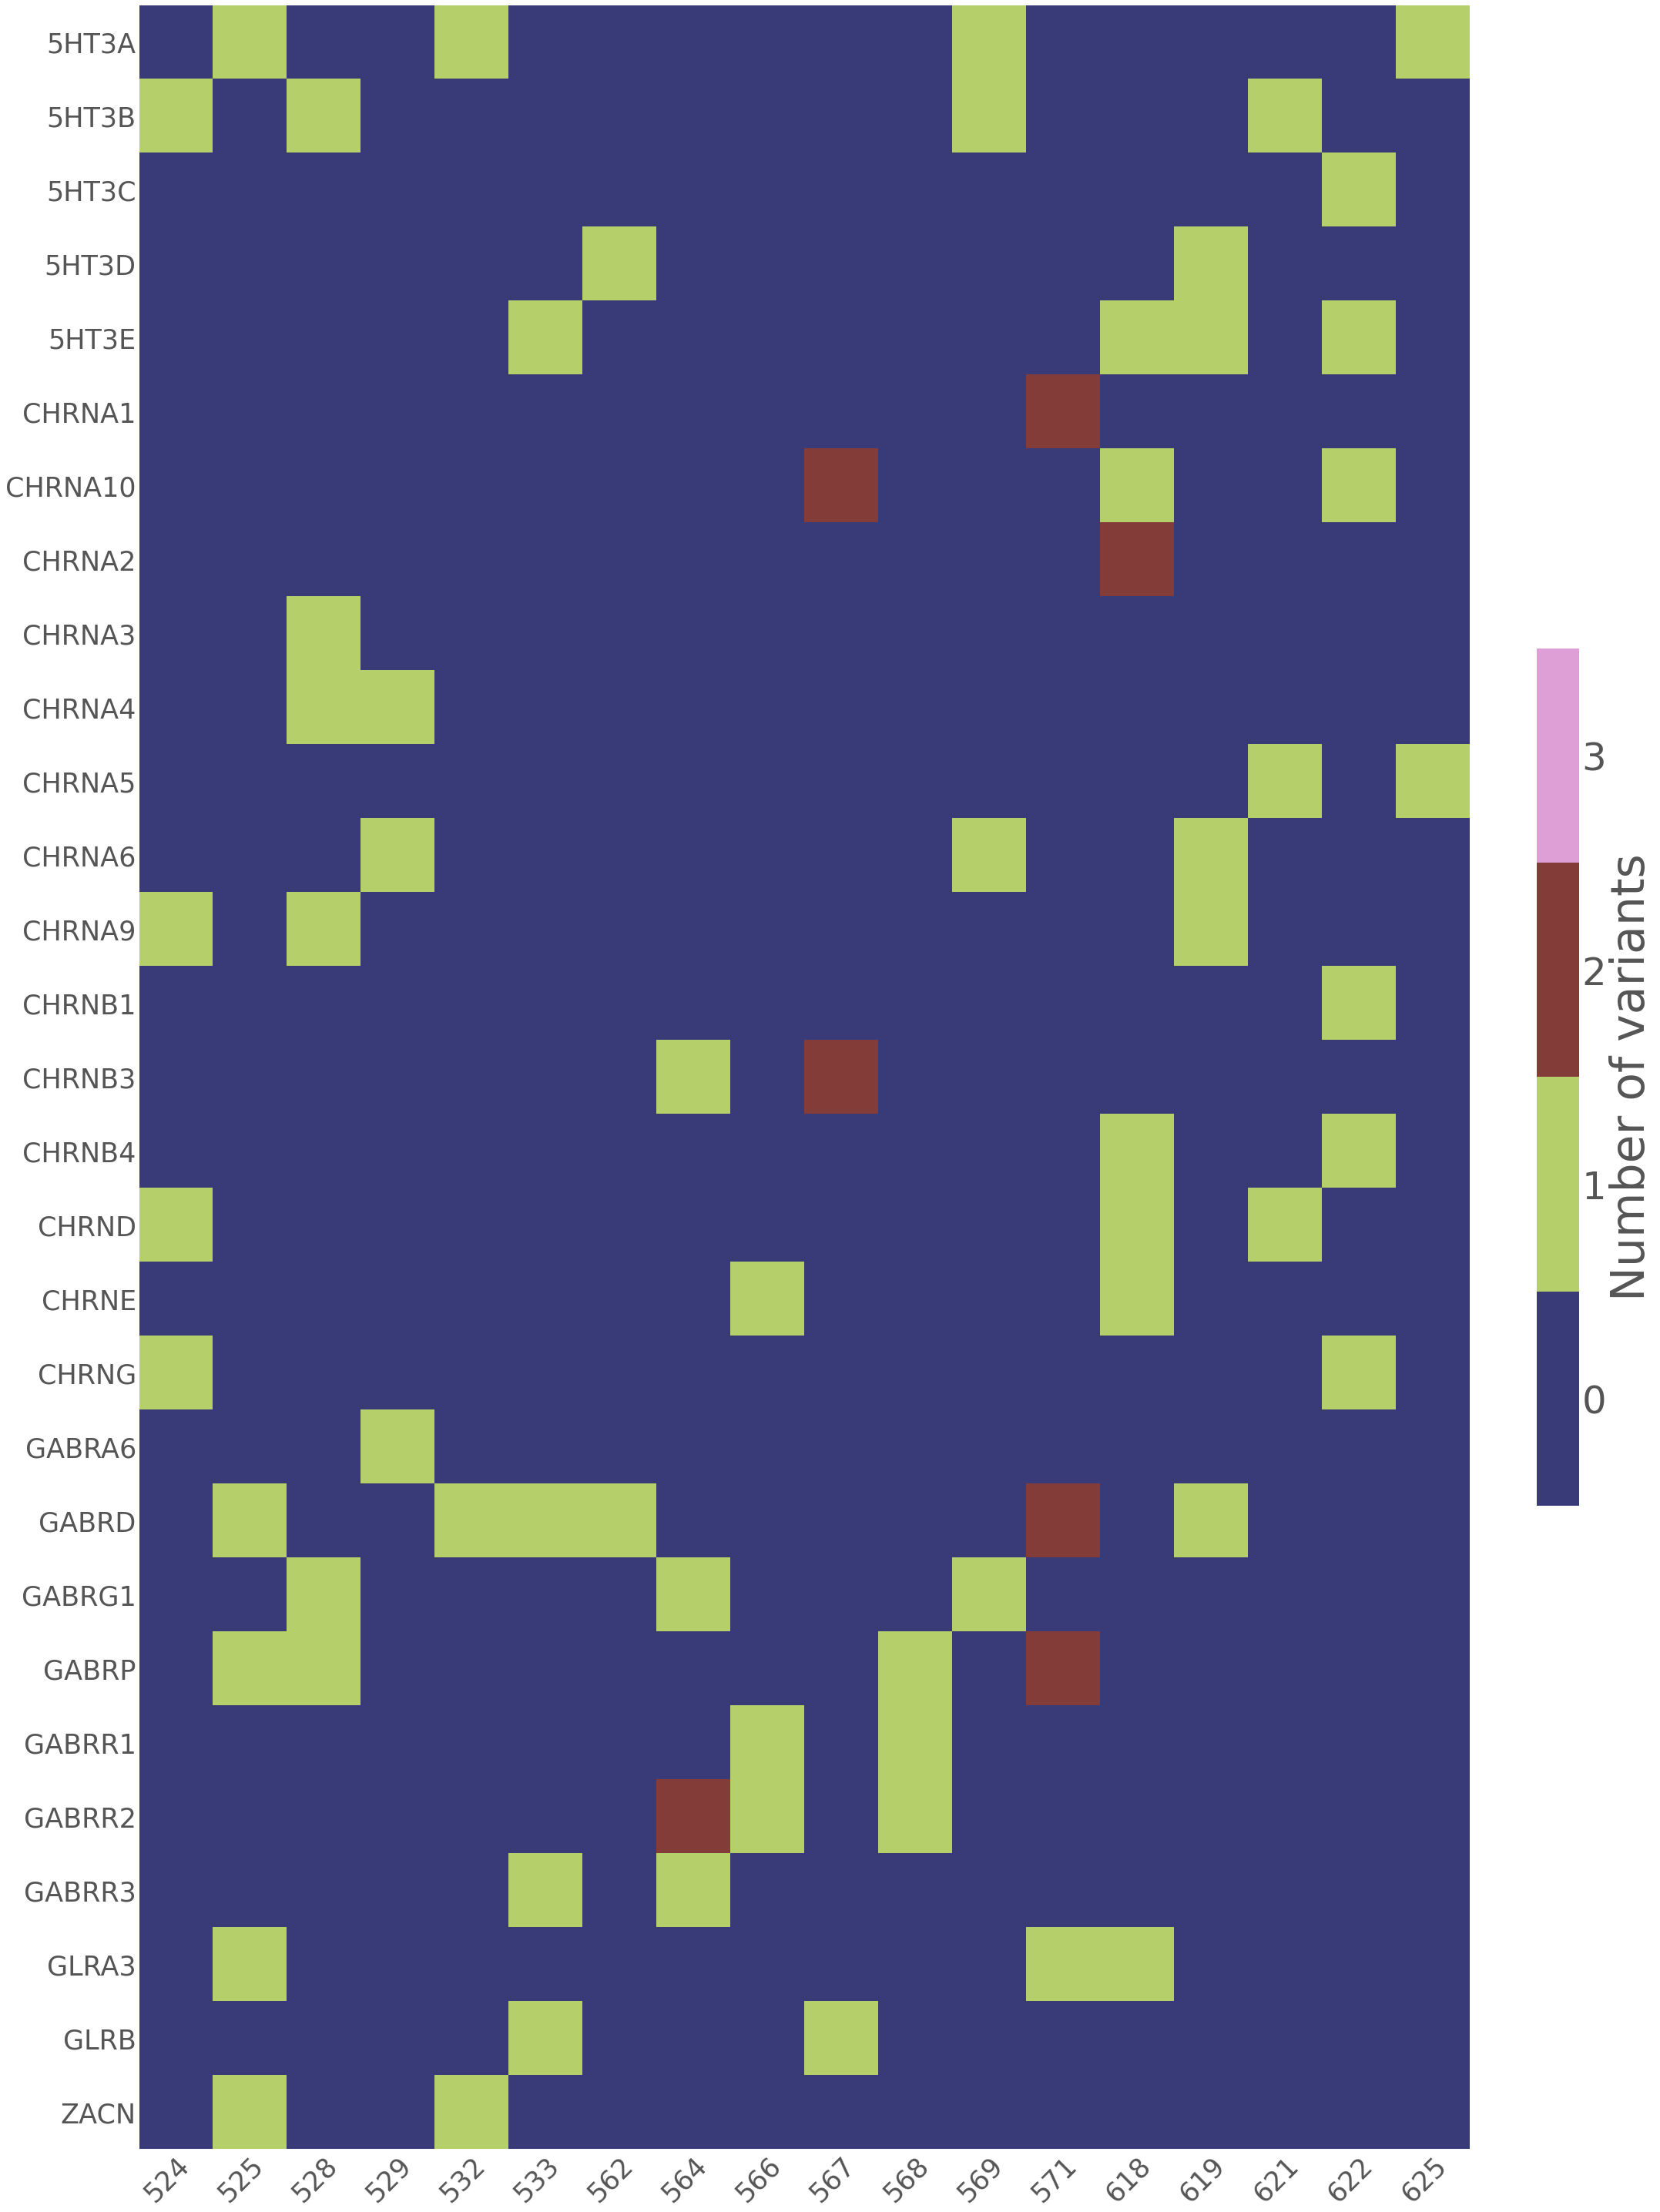

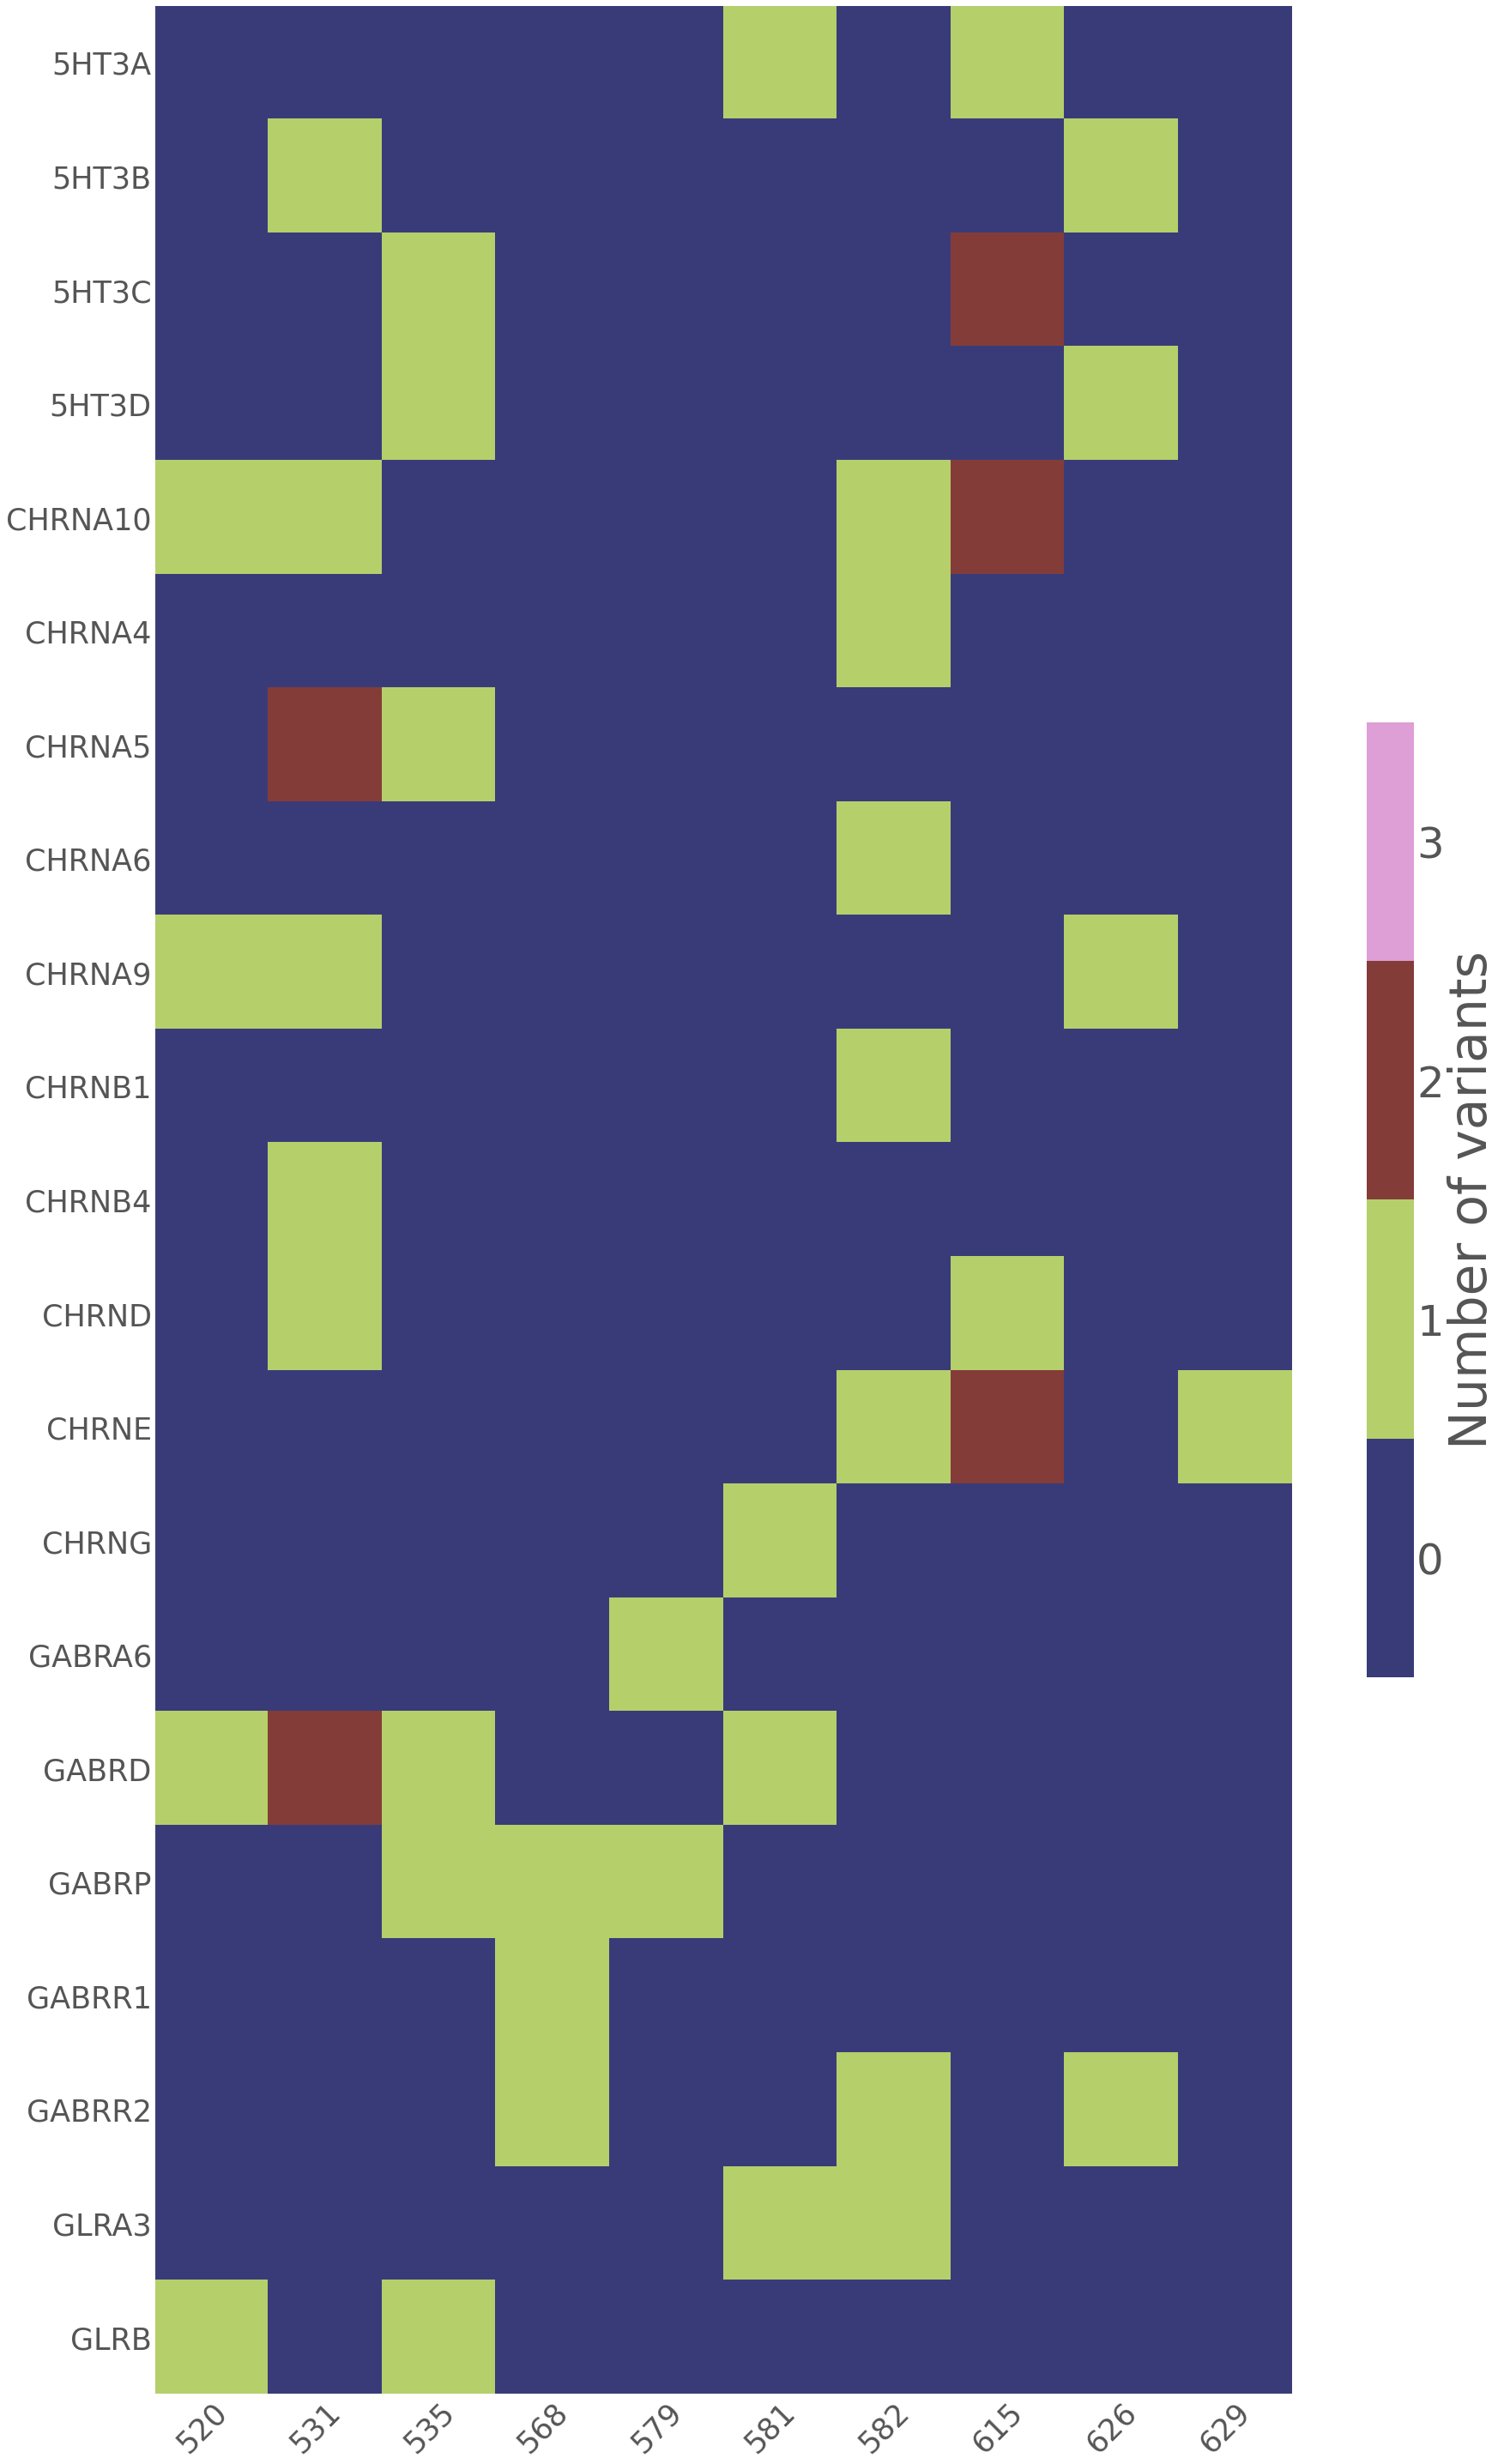

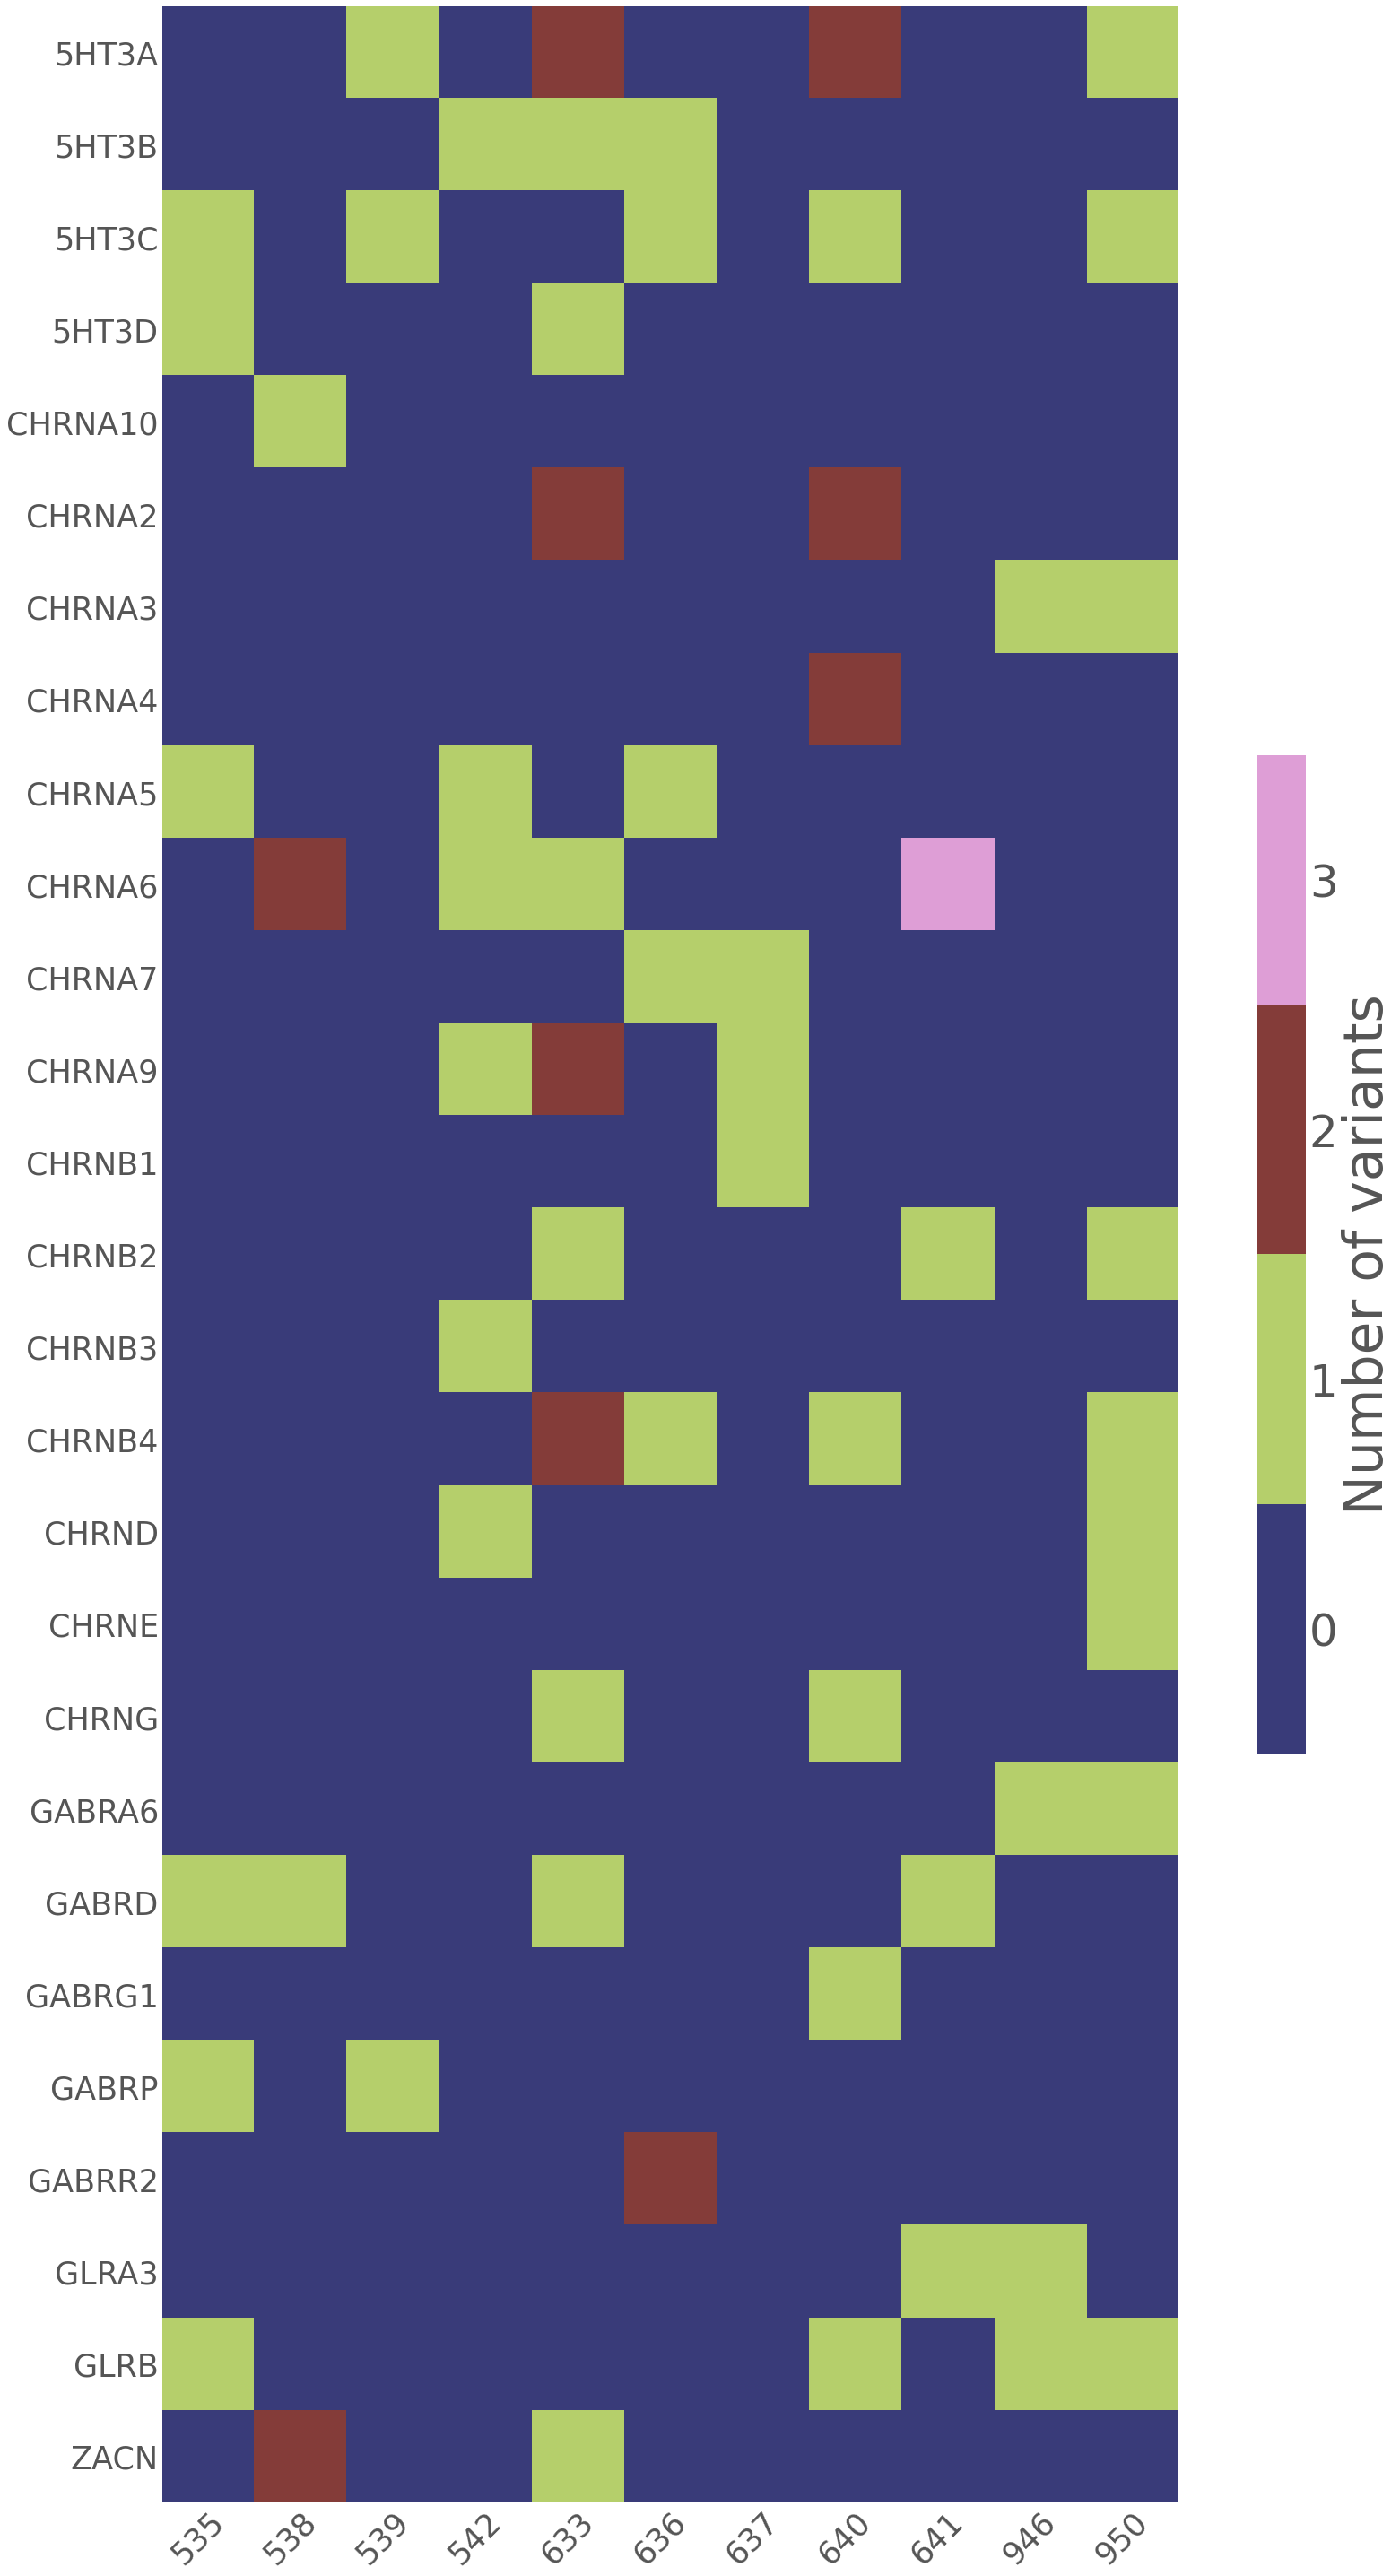

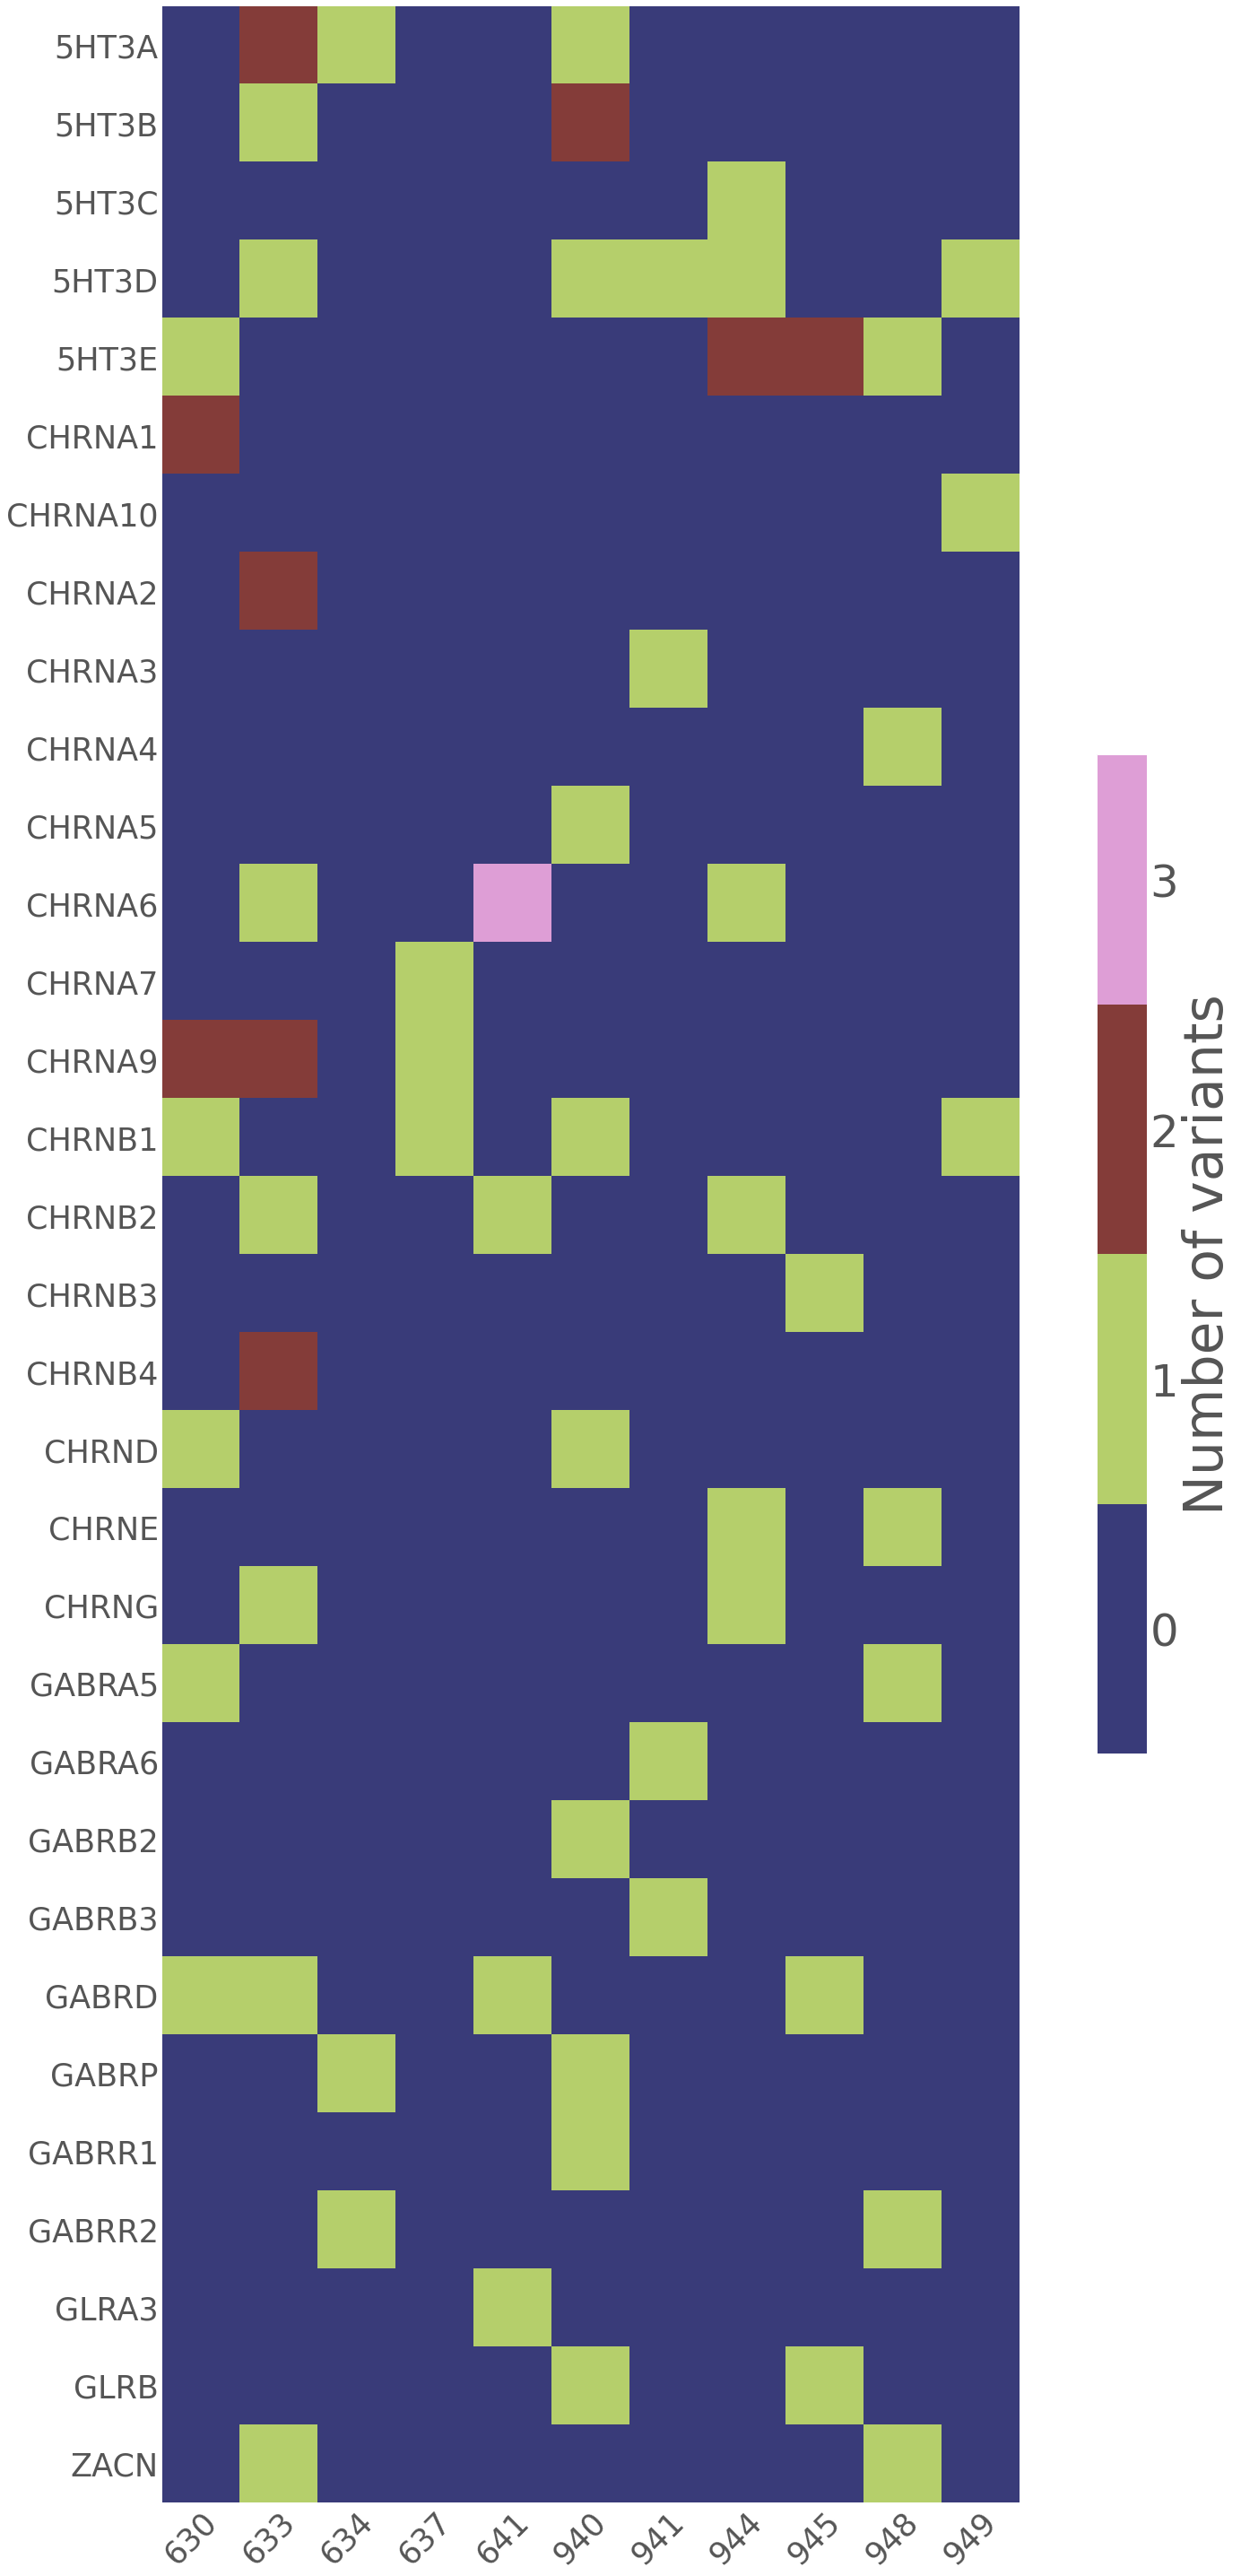

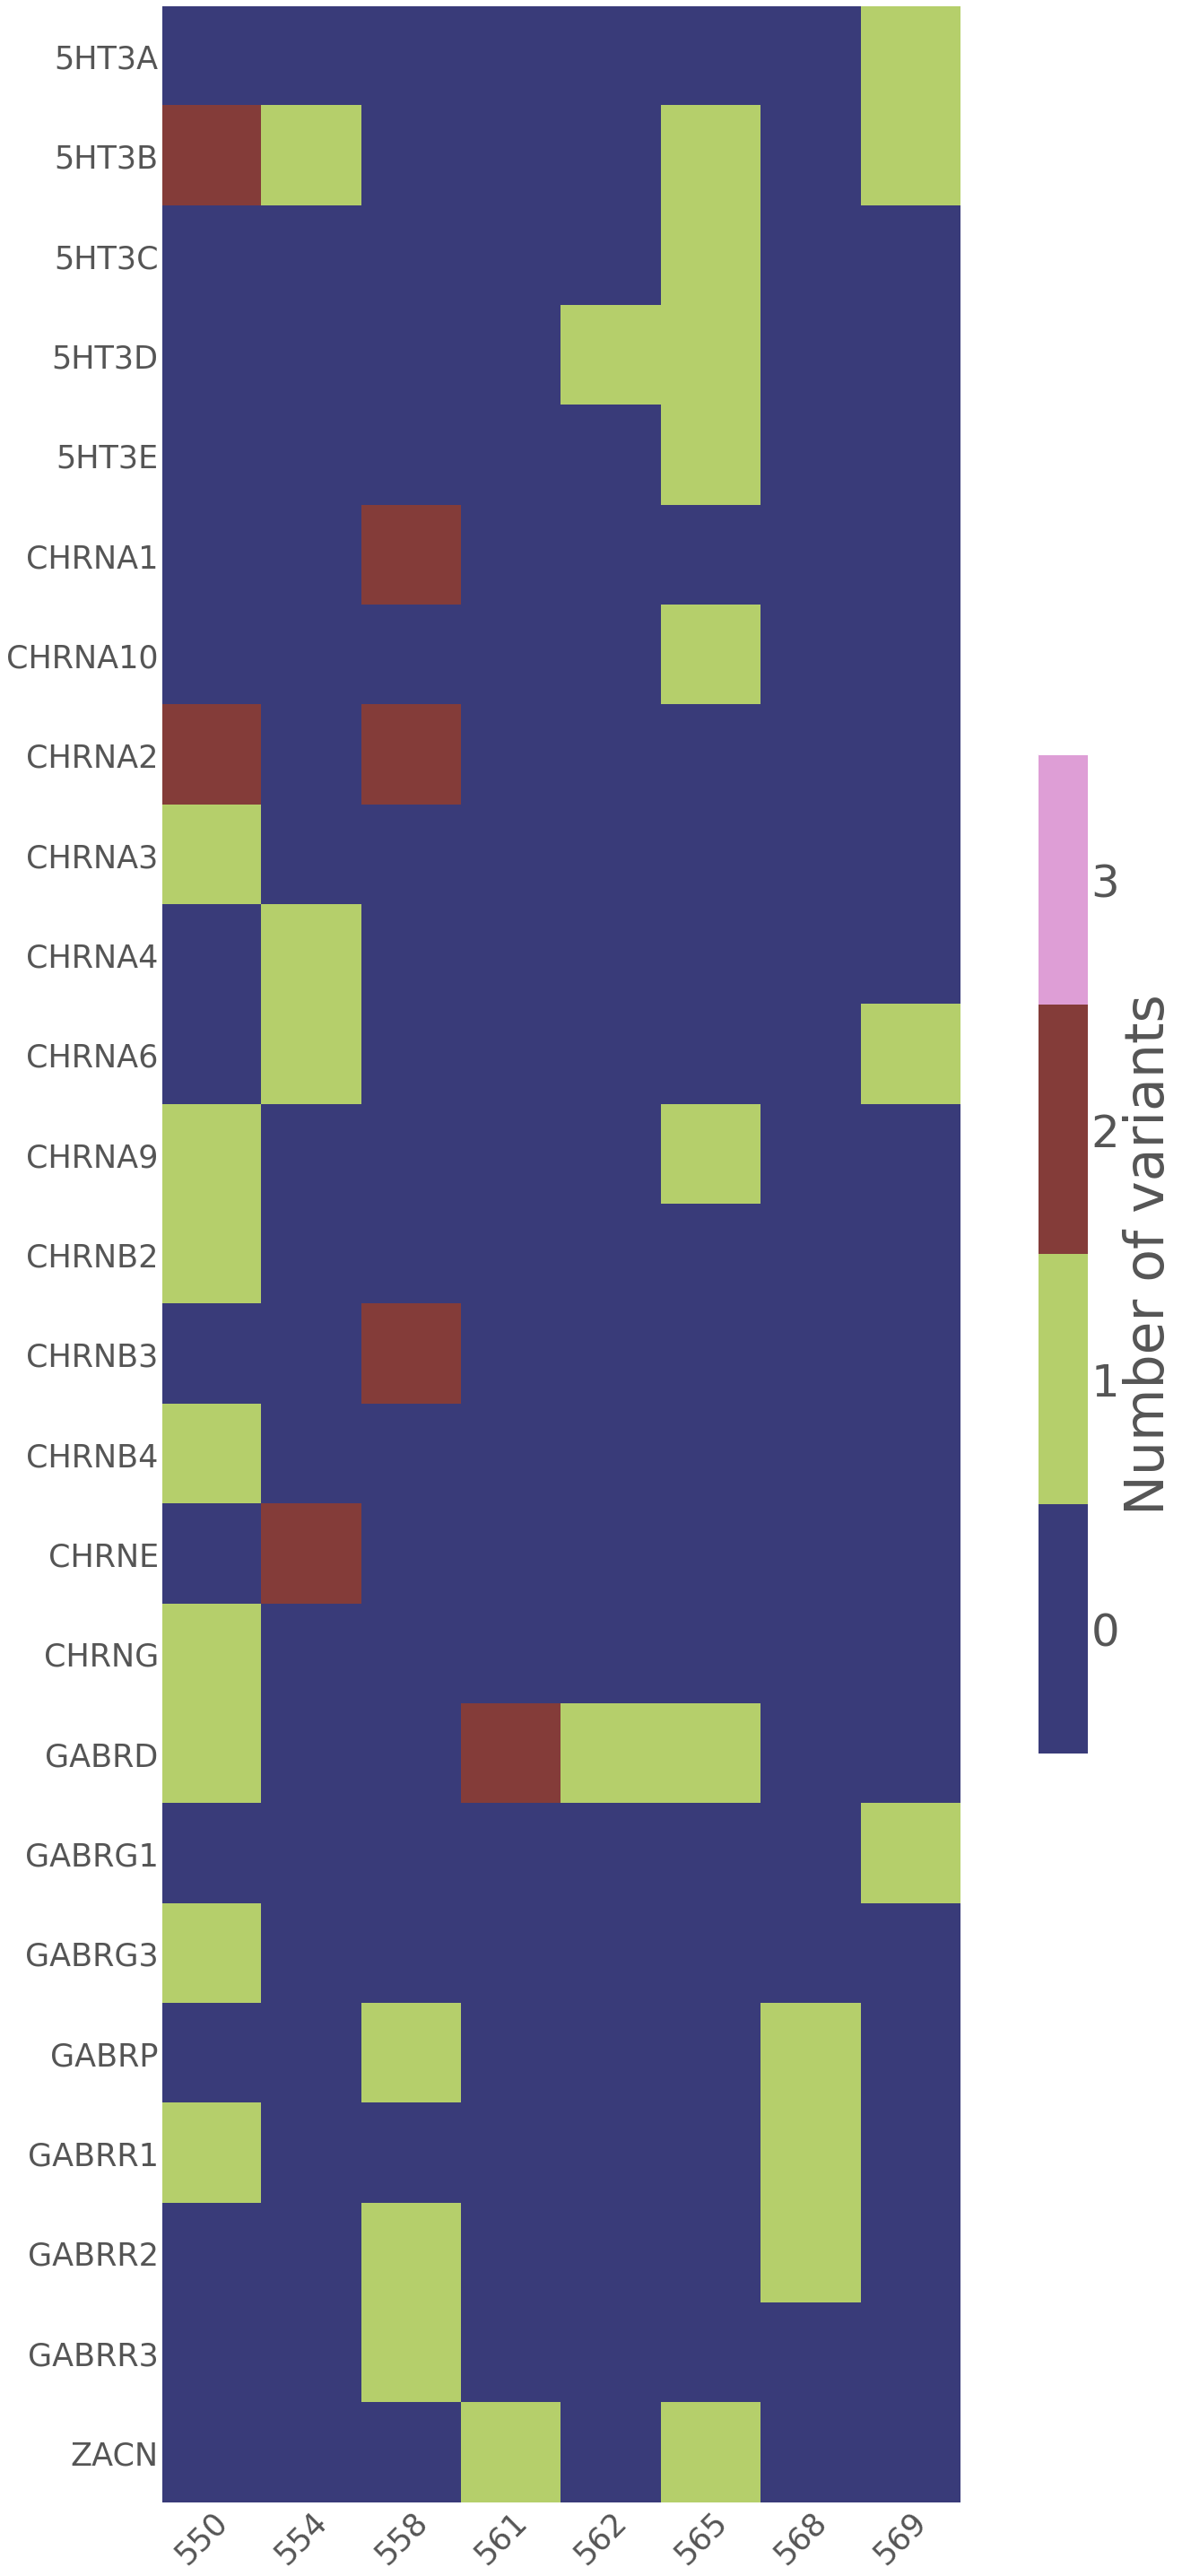

In [150]:
def plot_heatmap(data, aacids, genes, bs = "", title=True, save=True):
    pyplot.rcParams["axes.grid"] = False

    matplotlib.rcParams["figure.figsize"] = (120, 40)

    cmap = pyplot.get_cmap("tab20b")
    boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N)
    fig, ax = pyplot.subplots()
    im = ax.imshow(data, cmap=cmap, norm=norm, interpolation="nearest")

    cbar = pyplot.colorbar(im, ax=ax, shrink=0.4, pad=0.01)
    cbar.set_ticks([0, 1, 2, 3])
    cbar.ax.tick_params(labelsize=50, size=0)
    cbar.set_label("Number of variants", size=60)

    ax.set_xticks(numpy.arange(len(aacids)), labels=[str(aa) for aa in aacids])
    ax.set_yticks(numpy.arange(len(genes)), labels=genes)

    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", size=35)
    pyplot.setp(ax.get_yticklabels(), size=35)
    pyplot.tick_params(axis="both", which="both", length=0)

    if title:
        ax.set_title(bs)

    fig.tight_layout()
    pyplot.show()

    if save:
        fig.savefig(f"Export/Heatmap_{bs}_count.png", format="png", dpi=300, bbox_inches="tight")
    pyplot.rcParams["axes.grid"] = True

# Getting the correct palette and normalizing it for all the plots
cmap = pyplot.get_cmap("tab10")
norm = matplotlib.colors.BoundaryNorm([0, 1, 2, 3], cmap.N)

genes = [y for y in ali_class._sequences.keys() if ("_" not in y) and ("." not in y)]
genes = pandas.Series(genes).sort_values(ascending=True, ignore_index=True)

for bs in bs_interest:
    site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs])]

    aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs]
    data = numpy.array([[int(sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa))) for aa in aacids] for gene in genes])

    retained = data.sum(axis=1) != 0
    plot_heatmap(data[retained, :], aacids, genes[retained], bs, title=False, save=True)

# Exporting the binding site variants


In [187]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"].isin(bs_interest[:-1])])]
site_data = site_data[["rsIDs", "Chromosome", "Position", "AA Referenced", "Gene", "Protein Consequence", "Allele Frequency"]]
site_data["BS"] = site_data["AA Referenced"].apply(lambda x: binding_sites["BS"][binding_sites.loc[binding_sites["AA Referenced"] == x].index[0]])
site_data[["AA Code", "AA Number"]] = pandas.DataFrame(site_data.apply(lambda x: ali_class.reference_to_aa(x["AA Referenced"], x["Gene"]), axis=1).tolist(), index=site_data.index)
site_data["Protein Consequence"] = site_data["Protein Consequence"].apply(lambda x: seq1(x[-3:]))
site_data

,rsIDs,Chromosome,Position,AA Referenced,Gene,Protein Consequence,Allele Frequency,BS,AA Code,AA Number
53,rs578165631,5,170808662.0,525,GABRP,K,0.000013,3 (upperTMD),E,248
54,rs373064332,5,170808671.0,528,GABRP,I,0.000066,3 (upperTMD),V,251
56,rs1409826344,5,170808692.0,535,GABRP,M,0.000013,3.5 (upperTMD - IVM),V,258
59,rs1238072570,5,170808704.0,539,GABRP,I,0.000013,4 (interface steroid site),V,262
62,rs200682907,5,170809605.0,568,GABRP,M,0.000013,3 (upperTMD),I,290
...,...,...,...,...,...,...,...,...,...,...
3661,rs926986572,15,78590209.0,542,CHRNA5,C,0.000013,4 (interface steroid site),Y,273
3666,rs116099178,15,78590340.0,621,CHRNA5,V,0.000177,3 (upperTMD),L,317
3667,rs74865777,15,78590352.0,625,CHRNA5,V,0.000138,3 (upperTMD),M,321
3668,rs201259246,15,78590385.0,636,CHRNA5,I,0.000026,4 (interface steroid site),V,332


In [188]:
site_data.to_csv("Export/BS_variants.csv", index=False)

# Coloring the ribbon

In [ ]:
print(found_missense["Allele Frequency"].min()*100_000)
print(found_missense["Allele Frequency"].max()*100_000)

In [ ]:
output_data = pandas.DataFrame(found_missense[["Gene", "AA Referenced", "Protein Consequence", "Allele Frequency"]])
output_data["Allele Frequency"] = output_data["Allele Frequency"] * 100_000 # Convert to per 100_000 alleles

output_data["Position"] = output_data.apply(lambda y: ali_class.reference_to_aa(y["AA Referenced"], "7EKT.A")[1], axis = 1)
output_data_clean = output_data[output_data["Position"] != -1]
output_data_clean

In [ ]:
palette = matplotlib.colors.LinearSegmentedColormap.from_list("testCmap", [[0, 64/255, 1], [1, 0, 0]])
palette

In [ ]:
output_data_clean["Color"] = numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, palette((output_data_clean["Allele Frequency"]-output_data_clean["Allele Frequency"].min())*255/output_data_clean["Allele Frequency"].max()))
output_data_clean["Color"] = output_data_clean["Color"].str.replace("#", "0x")
print(output_data_clean)
# print(numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, palette([0, 255])))
# print(palette([0, 255]))

All the values should be normalized to 0-255 range!

In [ ]:
frequencies = output_data_clean.groupby(["Position"]).sum()["Allele Frequency"]
for i in range(1, len(str(ali_class._sequences["7EKT.A"].seq).replace("-", ""))+1):
    if i not in frequencies.index:
        frequencies[i] = 0
frequencies.sort_index(inplace=True)

colors = numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, palette((frequencies-frequencies.min())*255/frequencies.max()))
colors = pandas.Series(colors).str.replace("#", "0x")
colors

Fetching data on the conserved regions. We put it on the reference so we will be able to produce later the variant heatmaps for variable regions.

In [ ]:
conserved_regions = pandas.read_csv("Conserved_segments.csv")
conserved_regions["AA Referenced"] = conserved_regions.apply(lambda y: ali_class.find_reference(y["Gene"], y["AA Name"], y["AA Number"]), axis=1)
conserved_regions

In [ ]:
colors = [col if i+1 in conserved_regions["AA Number"].values else "0xb3b300" for i, col in enumerate(colors)]

In [ ]:
with open("Colorings.csv", "w") as file:
    file.write("\n".join(colors))

In [ ]:
# colors.to_csv("Colorings.csv", index=False)

In [ ]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [ ]:
gradient = numpy.linspace(0, 1, 256)
gradient = numpy.vstack((gradient, gradient))

# Create figure and adjust figure height to number of colormaps
nrows = 1
figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
fig, axs = pyplot.subplots(nrows=nrows + 1, figsize=(30, 10))

axs[0].imshow(gradient, aspect='auto', cmap=palette)

# Turn off *all* ticks & spines, not just the ones with colormaps.
for ax in axs:
    ax.set_axis_off()

In [ ]:
print(frequencies.min())
print(frequencies.max())

In [ ]:
len([x for x in ali_class._sequences.keys() if "_" not in x])

### Variable regions

In [ ]:
variable_regions = []
last = len(conserved_regions["Region"].unique())+1
for i in range(0, last):
    if i == 0:
        minimum = 1
    else:
        minimum = conserved_regions["AA Referenced"][conserved_regions["Region"] == i].max()+1
    if i == last-1:
        maximum = len(ali_class._alignment[0])
    else:
        maximum = conserved_regions["AA Referenced"][conserved_regions["Region"] == i+1].min()-1
    variable_regions.append((minimum, maximum))

variable_regions = pandas.concat([pandas.DataFrame.from_dict({"Region":[i for _ in range(region[0], region[1]+1)], "AA Referenced": [j for j in range(region[0], region[1]+1)]}) for i, region in enumerate(variable_regions)], ignore_index=True)
variable_regions

In [ ]:
variable_regions[variable_regions["Region"] == 0]

### Sum of frequencies for each gene and region combination

In [ ]:
i = 0
genes = [y for y in ali_class._sequences.keys() if ("_" not in y) and ("." not in y)]
genes = pandas.Series(genes).sort_values(ascending=True, ignore_index=True)
regions = variable_regions["Region"].unique()
aacids = {reg: variable_regions["AA Referenced"][variable_regions["Region"] == reg] for reg in regions}

"""
data = numpy.zeros((len(genes), len(regions)))
for i, gene in enumerate(genes):
    for j in regions:
        value = sum(found_missense["Allele Frequency"][(found_missense["Gene"] == gene) & (found_missense["AA Referenced"].isin(aacids[i].values))
"""
data = numpy.array([[sum(found_missense["Allele Frequency"][(found_missense["Gene"] == gene) & (found_missense["AA Referenced"].isin(aacids[i].values))])*100_000 for i in regions] for gene in genes])

print(data)
print(len(data))

In [ ]:
def plot_heatmap(title=True, save=False):
    pyplot.rcParams["axes.grid"] = False

    matplotlib.rcParams["figure.figsize"] = (120, 40)

    fig, ax = pyplot.subplots()
    im = ax.imshow(data+1, norm=matplotlib.colors.LogNorm(), cmap=pyplot.get_cmap("bwr"), interpolation="nearest")

    cbar = pyplot.colorbar(im, ax=ax, shrink=0.5, pad=0.01)
    cbar.ax.tick_params(labelsize=50, size=0)
    cbar.set_label("Sum of alleles per 100,000", size=60)

    ax.set_xticks(regions, labels=[f"VR{i+1}" for i in regions])
    ax.set_yticks(numpy.arange(len(genes)), labels=genes)

    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", size=35)
    pyplot.setp(ax.get_yticklabels(), size=35)
    pyplot.tick_params(axis="both", which="both", length=0)

    if title:
        ax.set_title("Sum of variant numbers per 100,000 in variable regions")

    fig.tight_layout()
    pyplot.show()

    if save:
        fig.savefig(f"Variable regions_log.png", format="png", dpi=300, bbox_inches="tight")

    pyplot.rcParams["axes.grid"] = True

plot_heatmap(False, save=True)

### Heatmap of variant count per AA

In [ ]:
def length_calc(region, gene):
    aa_subset = variable_regions["AA Referenced"][variable_regions["Region"] == region]
    return len(str(ali_class._sequences[gene][aa_subset.min():aa_subset.max()].seq).replace("-", ""))

i = 0
genes = [y for y in ali_class._sequences.keys() if ("_" not in y) and ("." not in y)]
genes = pandas.Series(genes).sort_values(ascending=True, ignore_index=True)
regions = variable_regions["Region"].unique()
aacids = {reg: variable_regions["AA Referenced"][variable_regions["Region"] == reg] for reg in regions}
reg_lens = {reg: {gene: length_calc(reg, gene) for gene in genes} for reg in regions}

data = [[((found_missense["Gene"] == gene) & (found_missense["AA Referenced"].isin(aacids[i].values))).sum()/reg_lens[i][gene] if reg_lens[i][gene] else numpy.NaN for i in regions] for gene in genes]

print(data)
print(len(data))

In [ ]:
def plot_heatmap(title=True, save=False):
    pyplot.rcParams["axes.grid"] = False

    matplotlib.rcParams["figure.figsize"] = (120, 40)

    fig, ax = pyplot.subplots()
    im = ax.imshow(data, cmap=pyplot.get_cmap("bwr"), interpolation="nearest")

    cbar = pyplot.colorbar(im, ax=ax, shrink=0.5, pad=0.01)
    cbar.ax.tick_params(labelsize=50, size=0)
    cbar.set_label("Number of variants per amino acid", size=60)

    ax.set_xticks(regions, labels=[f"VR{i+1}" for i in regions])
    ax.set_yticks(numpy.arange(len(genes)), labels=genes)

    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", size=35)
    pyplot.setp(ax.get_yticklabels(), size=35)
    pyplot.tick_params(axis="both", which="both", length=0)

    if title:
        ax.set_title("Sum of variant numbers per 100,000 in variable regions")

    if save:
        fig.savefig(f"Variable regions_NperLen.png", format="png", dpi=300, bbox_inches="tight")

    fig.tight_layout()
    pyplot.show()

    pyplot.rcParams["axes.grid"] = True

plot_heatmap(False, save=True)